## Exploratory Data Analysis of YOLO-N and YOLO-M Performance on Road Damage Detection

This notebook presents an Exploratory Data Analysis (EDA) of the training results from two YOLO model variants — **YOLO-N** and **YOLO-M** — applied to a road damage detection dataset. The goal is to evaluate and compare their performance metrics, convergence behavior, and training dynamics under identical conditions.

Both models were trained using the same set of hyperparameters:

- **Dataset**: Specified via a configuration YAML file
- **Epochs**: 100
- **Image Size**: 640×640
- **Early Stopping Patience**: 100 epochs
- **Batch Size**: 32
- **Optimizer**: SGD with momentum (0.820698)
- **Learning Rate**: Initial `lr0=0.009799`, final `lr = lr0 * lrf = 0.00081` (with `lrf=0.082653`)
- **Dropout**: 0.122049
- **Weight Decay**: 0.00784
- **Device**: CUDA (device 0)
- **Seed**: 0 (for reproducibility)
- **Mixed Precision (AMP)**: Enabled
- **Deterministic Training**: Enabled
- **Validation and Plotting**: Enabled throughout training
- **Model Saving**: Enabled

In the following sections, we will analyze loss curves, precision-recall metrics, mAP, and other relevant indicators to understand the strengths and limitations of each model.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries successfully imported!")

Libraries successfully imported!


In [31]:
# Loading the datasets
df_yolo_n = pd.read_csv('runs/results-yolo-n.csv')
df_yolo_m = pd.read_csv('runs/results-yolo-m.csv')

# Adding a column to identify the model
df_yolo_n['model'] = 'YOLO-N'
df_yolo_m['model'] = 'YOLO-M'

print("=== GENERAL INFORMATION ===")
print(f"YOLO-N: {len(df_yolo_n)} epochs")
print(f"YOLO-M: {len(df_yolo_m)} epochs")
print(f"Number of columns: {len(df_yolo_n.columns)}")

print("\n=== FIRST 5 ROWS OF YOLO-N ===")
print(df_yolo_n.head())

print("\n=== FIRST 5 ROWS OF YOLO-M ===")
print(df_yolo_m.head())

print("\n=== DATA STRUCTURE ===")
print("YOLO-N:")
print(df_yolo_n.info())
print("\nYOLO-M:")
print(df_yolo_m.info())

=== GENERAL INFORMATION ===
YOLO-N: 100 epochs
YOLO-M: 100 epochs
Number of columns: 16

=== FIRST 5 ROWS OF YOLO-N ===
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   25.2972         2.56076         4.21572         1.93016   
1      2   48.3519         2.27196         2.90688         1.70912   
2      3   70.8902         2.25482         2.68622         1.65404   
3      4   93.6834         2.23371         2.56859         1.62305   
4      5  116.2990         2.21006         2.47983         1.60979   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00307            0.39568           0.04546   
1               0.50319            0.14230           0.22864   
2               0.36356            0.27473           0.25469   
3               0.29665            0.24146           0.22149   
4               0.29999            0.20349           0.19688   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0

In [32]:
def analyze_data_quality(df, model_name):
    print(f"\n=== DATA QUALITY ANALYSIS - {model_name} ===")
    
    # Missing values
    missing_values = df.isnull().sum()
    print(f"Missing values per column:")
    for col, missing in missing_values.items():
        if missing > 0:
            print(f"  {col}: {missing} ({missing/len(df)*100:.2f}%)")
    
    if missing_values.sum() == 0:
        print("  No missing values found!")
    
    # Duplicate rows
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")
    
    # Outlier detection for key metrics using IQR
    key_metrics = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']
    
    print(f"Outlier analysis (using IQR):")
    for metric in key_metrics:
        if metric in df.columns:
            Q1 = df[metric].quantile(0.25)
            Q3 = df[metric].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[metric] < lower_bound) | (df[metric] > upper_bound)]
            print(f"  {metric}: {len(outliers)} outlier(s)")
    
    return df

# Analysis for both models
df_yolo_n_clean = analyze_data_quality(df_yolo_n, "YOLO-N")
df_yolo_m_clean = analyze_data_quality(df_yolo_m, "YOLO-M")


=== DATA QUALITY ANALYSIS - YOLO-N ===
Missing values per column:
  No missing values found!
Duplicate rows: 0
Outlier analysis (using IQR):
  metrics/mAP50(B): 7 outlier(s)
  metrics/mAP50-95(B): 4 outlier(s)
  metrics/precision(B): 4 outlier(s)
  metrics/recall(B): 5 outlier(s)

=== DATA QUALITY ANALYSIS - YOLO-M ===
Missing values per column:
  No missing values found!
Duplicate rows: 0
Outlier analysis (using IQR):
  metrics/mAP50(B): 9 outlier(s)
  metrics/mAP50-95(B): 10 outlier(s)
  metrics/precision(B): 5 outlier(s)
  metrics/recall(B): 9 outlier(s)


In [33]:
print("=== DETAILED DESCRIPTIVE STATISTICS ===")

# Key metrics for analysis
key_metrics = [
    'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss'
]

def detailed_statistics(df, model_name):
    print(f"\n--- {model_name} ---")
    stats_df = df[key_metrics].describe()
    
    # Adding extra statistics
    stats_df.loc['variance'] = df[key_metrics].var()
    stats_df.loc['skewness'] = df[key_metrics].skew()
    stats_df.loc['kurtosis'] = df[key_metrics].kurtosis()
    
    print(stats_df.round(4))
    return stats_df

stats_yolo_n = detailed_statistics(df_yolo_n, "YOLO-N")
stats_yolo_m = detailed_statistics(df_yolo_m, "YOLO-M")

# Comparison of means
print("\n=== MEANS COMPARISON ===")
comparison_df = pd.DataFrame({
    'YOLO-N': df_yolo_n[key_metrics].mean(),
    'YOLO-M': df_yolo_m[key_metrics].mean()
})
comparison_df['Difference'] = comparison_df['YOLO-M'] - comparison_df['YOLO-N']
comparison_df['Diff_%'] = (comparison_df['Difference'] / comparison_df['YOLO-N']) * 100

print(comparison_df.round(4))

=== DETAILED DESCRIPTIVE STATISTICS ===

--- YOLO-N ---
                 time  train/box_loss  train/cls_loss  train/dfl_loss  \
count        100.0000        100.0000        100.0000        100.0000   
mean        1171.4459          1.7596          1.5544          1.3351   
std          671.4446          0.2507          0.5049          0.1514   
min           25.2972          1.2958          0.9069          1.1096   
25%          597.6978          1.5761          1.2002          1.2128   
50%         1176.8950          1.7471          1.4559          1.3147   
75%         1744.8675          1.9302          1.7889          1.4259   
max         2307.6700          2.5608          4.2157          1.9302   
variance  450837.8162          0.0629          0.2549          0.0229   
skewness      -0.0130          0.3387          1.9197          0.9205   
kurtosis      -1.2046         -0.0058          6.9398          1.3282   

          metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)

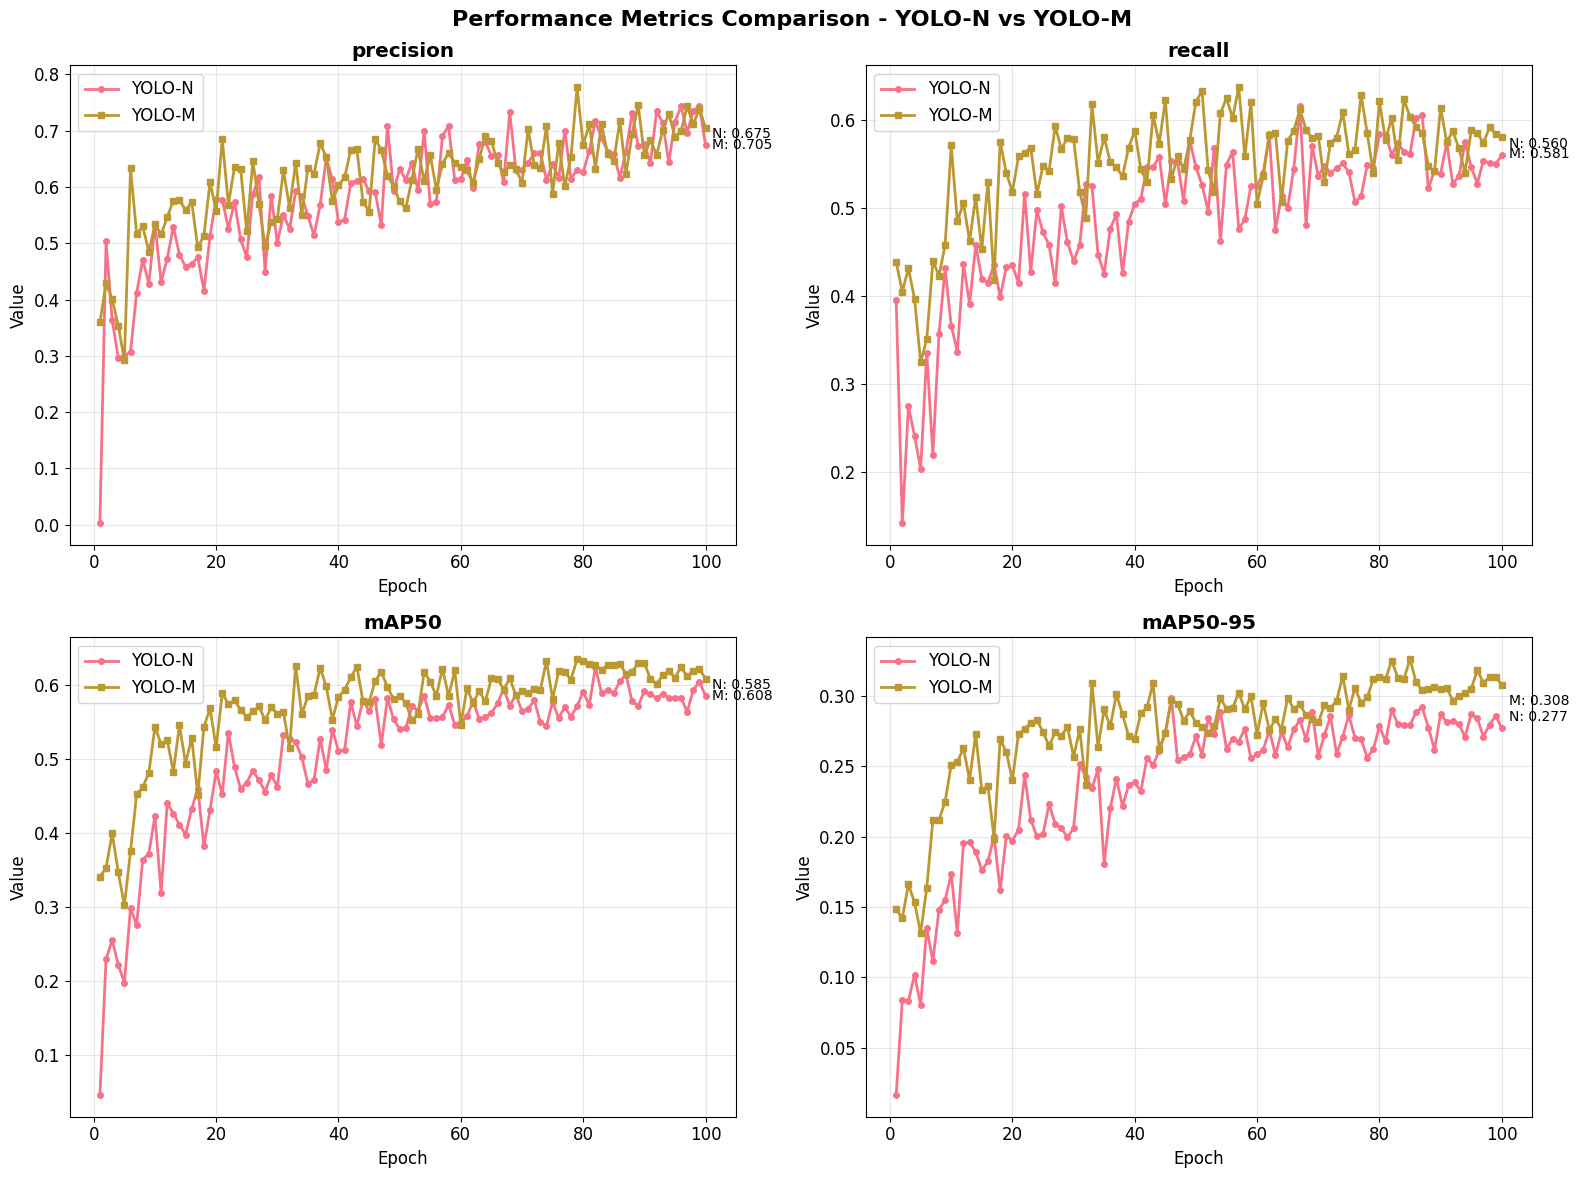

In [34]:
# Combine datasets for comparative visualizations
df_combined = pd.concat([df_yolo_n, df_yolo_m], ignore_index=True)

# Main performance metrics
performance_metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Metrics Comparison - YOLO-N vs YOLO-M', fontsize=16, fontweight='bold')

for i, metric in enumerate(performance_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Line plot for both models
    ax.plot(df_yolo_n['epoch'], df_yolo_n[metric], 'o-', label='YOLO-N', linewidth=2, markersize=4)
    ax.plot(df_yolo_m['epoch'], df_yolo_m[metric], 's-', label='YOLO-M', linewidth=2, markersize=4)
    
    ax.set_title(f'{metric.replace("metrics/", "").replace("(B)", "")}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add annotations for final values
    final_n = df_yolo_n[metric].iloc[-1]
    final_m = df_yolo_m[metric].iloc[-1]
    ax.annotate(f'N: {final_n:.3f}', xy=(df_yolo_n['epoch'].iloc[-1], final_n), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)
    ax.annotate(f'M: {final_m:.3f}', xy=(df_yolo_m['epoch'].iloc[-1], final_m), 
                xytext=(5, -15), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

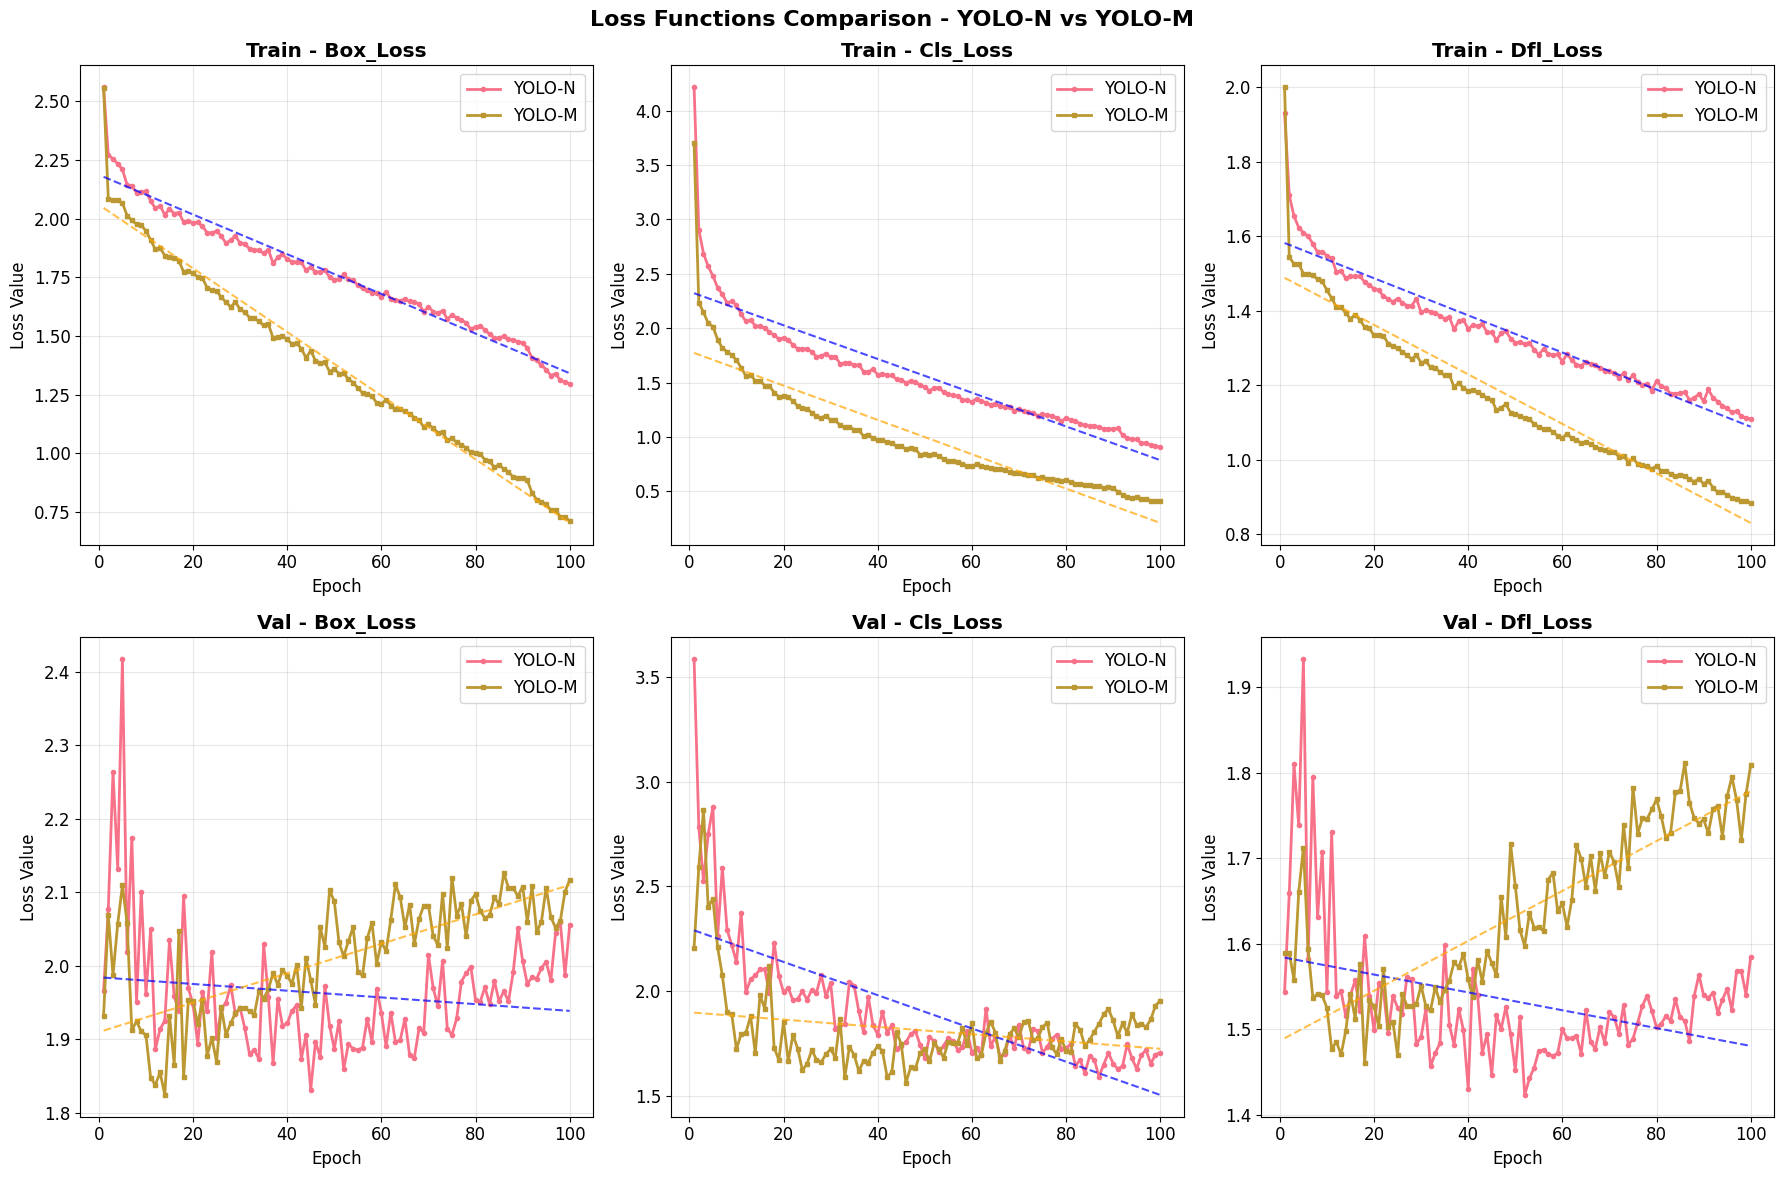

In [35]:
loss_metrics = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Loss Functions Comparison - YOLO-N vs YOLO-M', fontsize=16, fontweight='bold')

for i, metric in enumerate(loss_metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    ax.plot(df_yolo_n['epoch'], df_yolo_n[metric], 'o-', label='YOLO-N', linewidth=2, markersize=3)
    ax.plot(df_yolo_m['epoch'], df_yolo_m[metric], 's-', label='YOLO-M', linewidth=2, markersize=3)
    
    ax.set_title(f'{metric.replace("/", " - ").title()}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Highlight downward trend
    if len(df_yolo_n) > 1:
        z_n = np.polyfit(df_yolo_n['epoch'], df_yolo_n[metric], 1)
        ax.plot(df_yolo_n['epoch'], np.poly1d(z_n)(df_yolo_n['epoch']), '--', alpha=0.7, color='blue')
    
    if len(df_yolo_m) > 1:
        z_m = np.polyfit(df_yolo_m['epoch'], df_yolo_m[metric], 1)
        ax.plot(df_yolo_m['epoch'], np.poly1d(z_m)(df_yolo_m['epoch']), '--', alpha=0.7, color='orange')

plt.tight_layout()
plt.show()

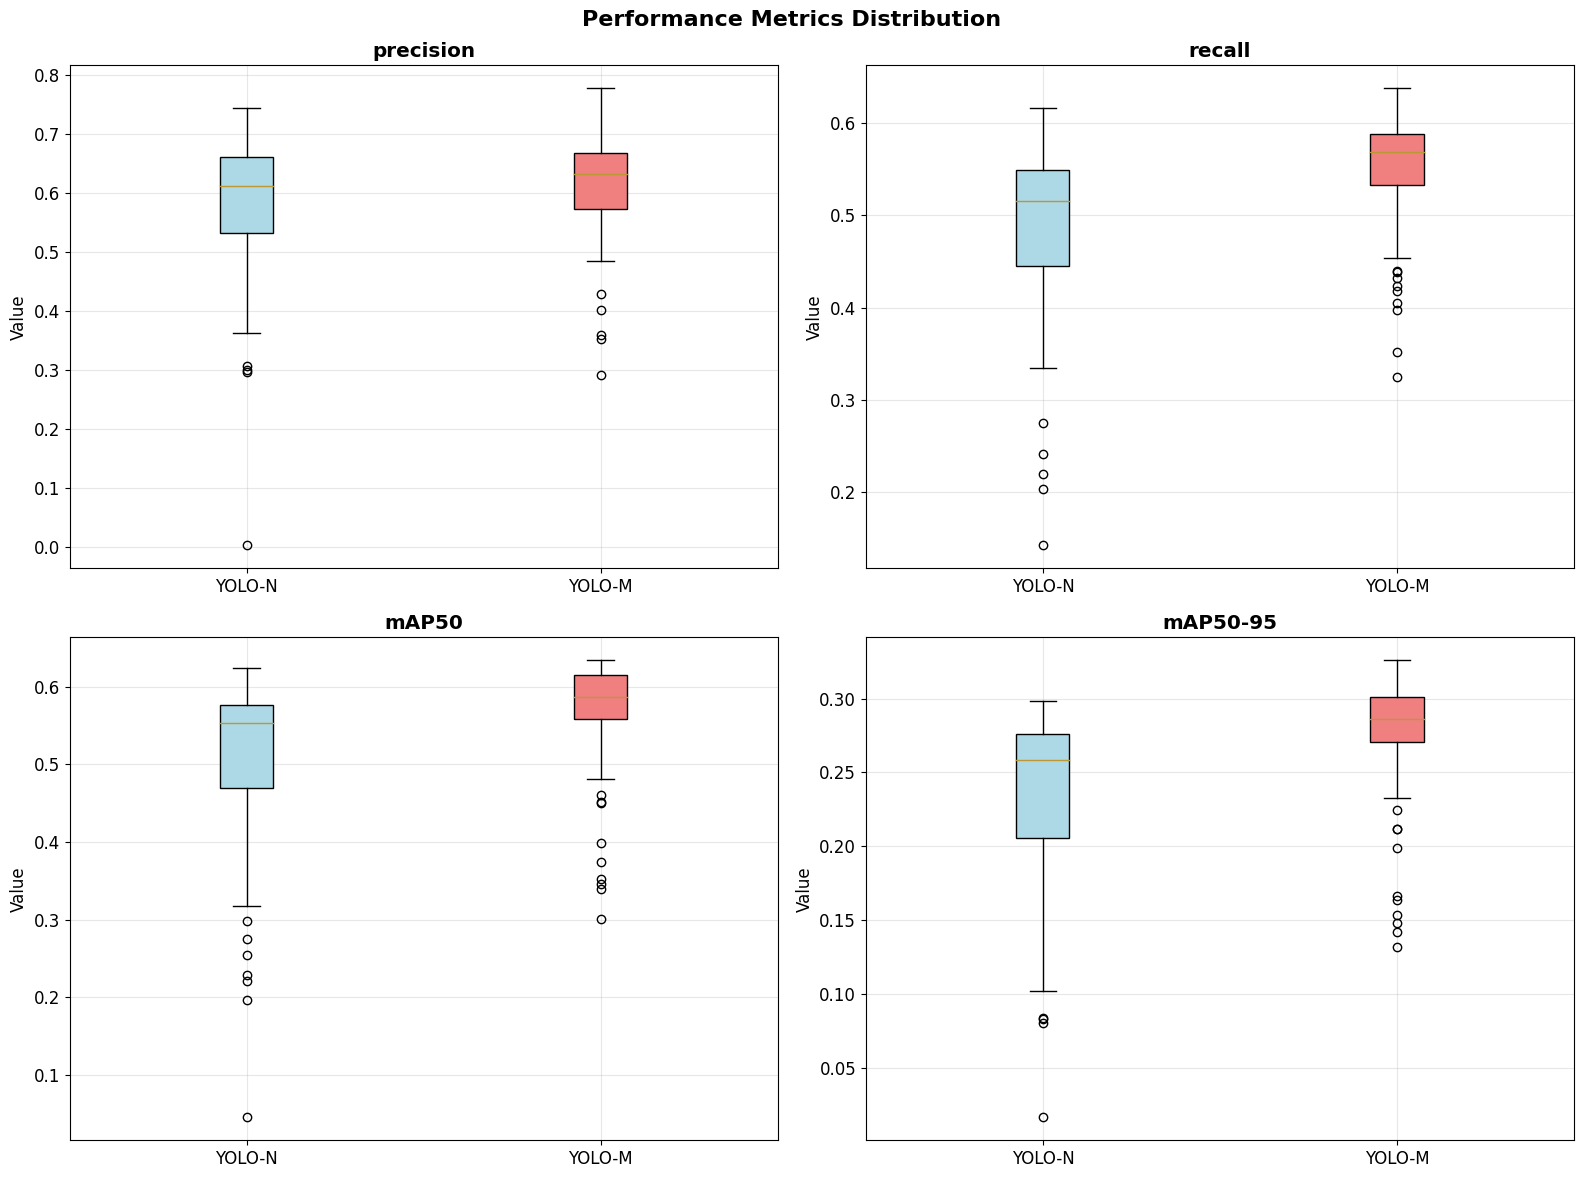

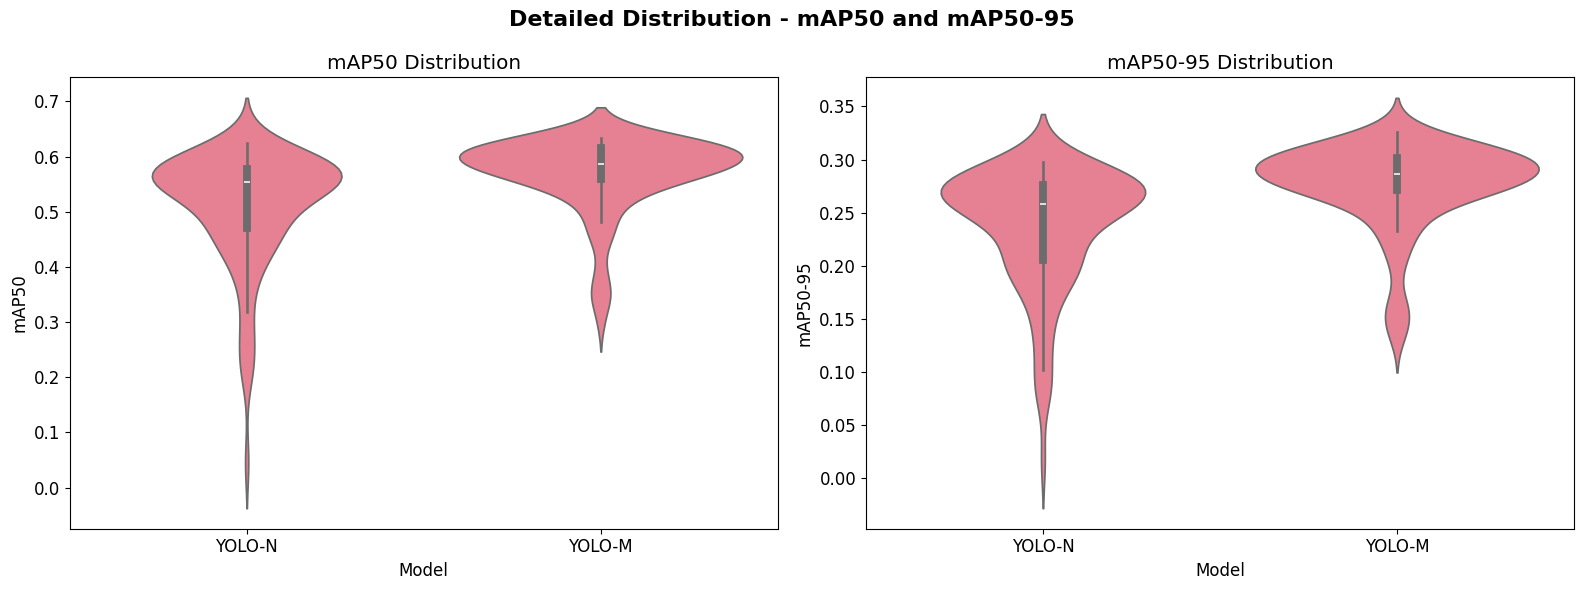

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Metrics Distribution', fontsize=16, fontweight='bold')

# Boxplot for main metrics
for i, metric in enumerate(performance_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    data_to_plot = [df_yolo_n[metric], df_yolo_m[metric]]
    bp = ax.boxplot(data_to_plot, labels=['YOLO-N', 'YOLO-M'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{metric.replace("metrics/", "").replace("(B)", "")}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Violin plots for a more detailed view of the distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Detailed Distribution - mAP50 and mAP50-95', fontsize=16, fontweight='bold')

# mAP50
data_map50 = pd.DataFrame({
    'YOLO-N': df_yolo_n['metrics/mAP50(B)'],
    'YOLO-M': df_yolo_m['metrics/mAP50(B)']
})
data_map50_melted = data_map50.melt(var_name='Model', value_name='mAP50')
sns.violinplot(data=data_map50_melted, x='Model', y='mAP50', ax=axes[0])
axes[0].set_title('mAP50 Distribution')

# mAP50-95
data_map5095 = pd.DataFrame({
    'YOLO-N': df_yolo_n['metrics/mAP50-95(B)'],
    'YOLO-M': df_yolo_m['metrics/mAP50-95(B)']
})
data_map5095_melted = data_map5095.melt(var_name='Model', value_name='mAP50-95')
sns.violinplot(data=data_map5095_melted, x='Model', y='mAP50-95', ax=axes[1])
axes[1].set_title('mAP50-95 Distribution')

plt.tight_layout()

plt.show()

=== CONVERGENCE ANALYSIS ===
    model                metric  final_value   slope  r_squared  p_value  \
0  YOLO-N  metrics/precision(B)       0.6747  0.0032     0.6415      0.0   
1  YOLO-M  metrics/precision(B)       0.7048  0.0022     0.5713      0.0   
2  YOLO-N     metrics/recall(B)       0.5604  0.0024     0.5936      0.0   
3  YOLO-M     metrics/recall(B)       0.5812  0.0013     0.3867      0.0   
4  YOLO-N      metrics/mAP50(B)       0.5846  0.0029     0.6427      0.0   
5  YOLO-M      metrics/mAP50(B)       0.6077  0.0017     0.5436      0.0   
6  YOLO-N   metrics/mAP50-95(B)       0.2768  0.0016     0.6849      0.0   
7  YOLO-M   metrics/mAP50-95(B)       0.3079  0.0011     0.5905      0.0   

   std_dev      cv  stability_score  
0   0.1146  0.1956           0.8972  
1   0.0846  0.1376           0.9220  
2   0.0883  0.1800           0.9189  
3   0.0609  0.1105           0.9426  
4   0.1033  0.2027           0.9064  
5   0.0685  0.1203           0.9359  
6   0.0559  0.2363  

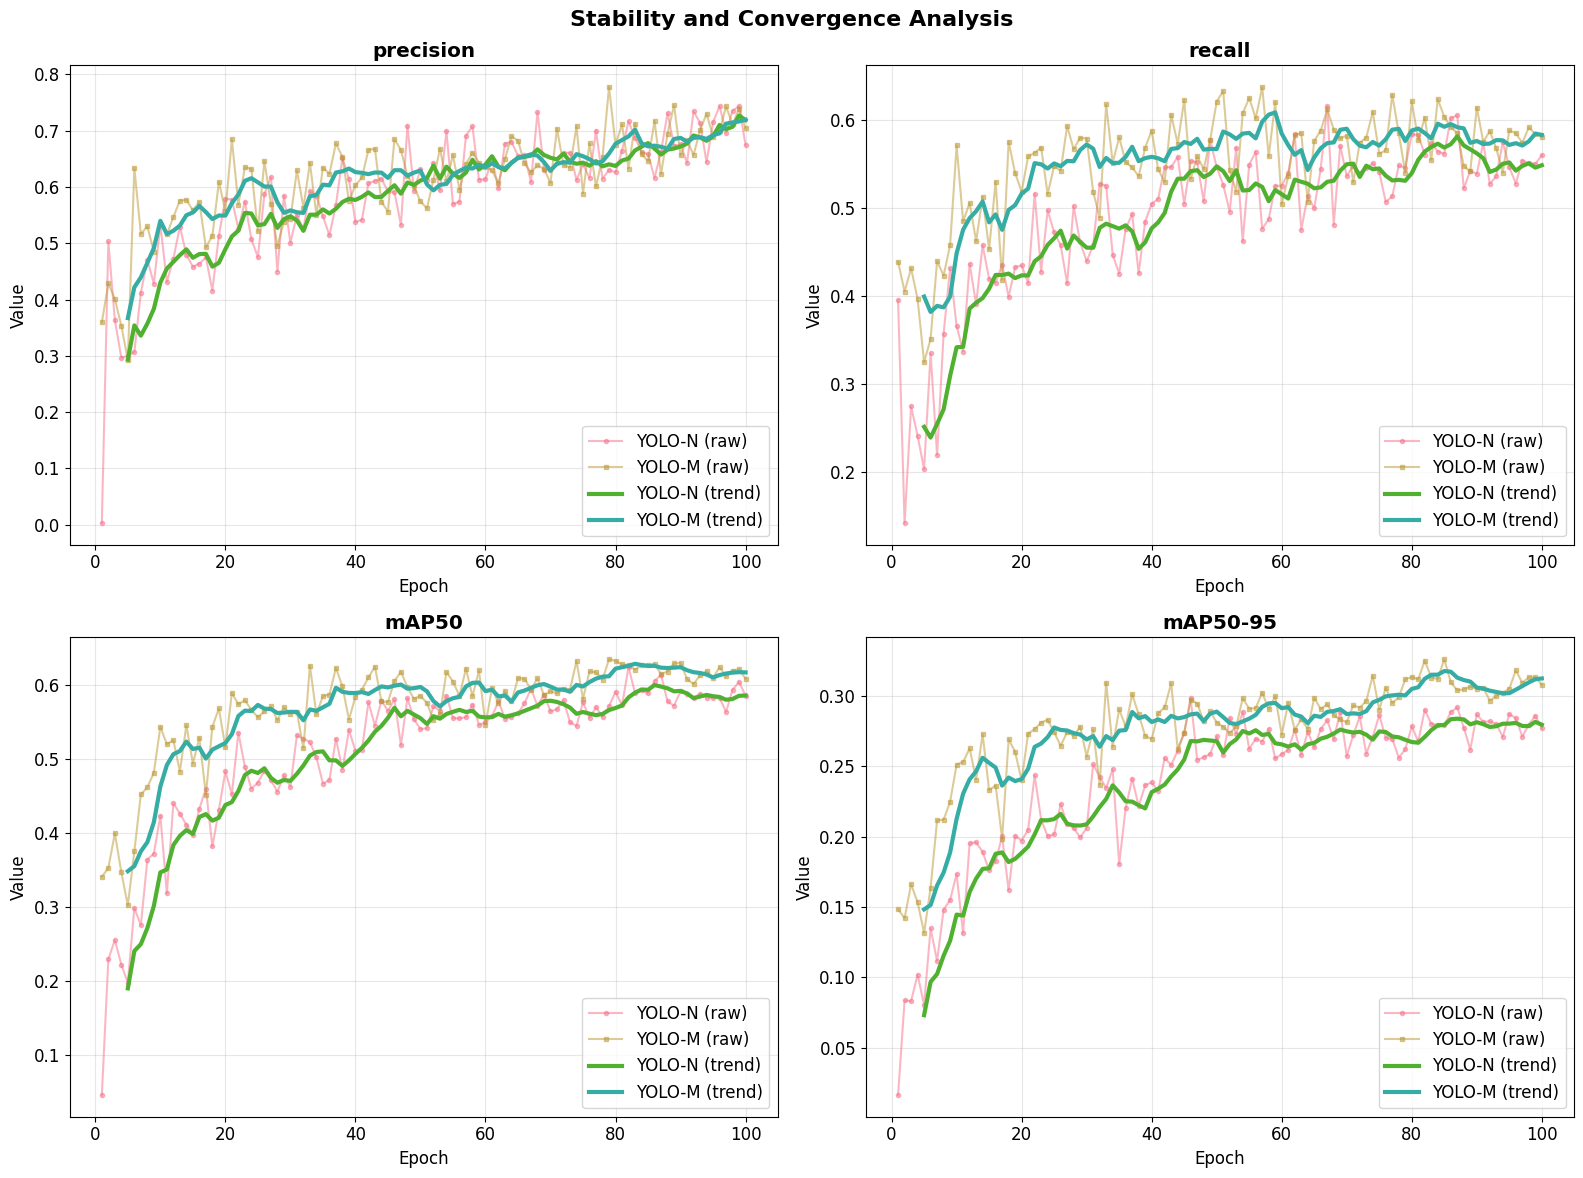

In [37]:
def analyze_convergence(df, model_name, metric):
    """Analyze the convergence of a metric"""
    values = df[metric].values
    
    # Compute rolling variance
    window_size = min(5, len(values)//2)
    if window_size >= 2:
        rolling_var = pd.Series(values).rolling(window=window_size).var()
        
        # General trend (linear regression)
        if len(values) > 1:
            slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(values)), values)
            
            return {
                'model': model_name,
                'metric': metric,
                'final_value': values[-1],
                'slope': slope,
                'r_squared': r_value**2,
                'p_value': p_value,
                'std_dev': np.std(values),
                'cv': np.std(values) / np.mean(values) if np.mean(values) != 0 else np.inf,
                'stability_score': 1 / (1 + np.std(values))  # Higher = more stable
            }
    return None

# Convergence analysis for main metrics
convergence_results = []

for metric in performance_metrics:
    result_n = analyze_convergence(df_yolo_n, 'YOLO-N', metric)
    result_m = analyze_convergence(df_yolo_m, 'YOLO-M', metric)
    
    if result_n and result_m:
        convergence_results.extend([result_n, result_m])

convergence_df = pd.DataFrame(convergence_results)
print("=== CONVERGENCE ANALYSIS ===")
print(convergence_df.round(4))

# Stability visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stability and Convergence Analysis', fontsize=16, fontweight='bold')

for i, metric in enumerate(performance_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Compute rolling mean
    window = min(5, len(df_yolo_n)//2)
    if window >= 2:
        rolling_mean_n = df_yolo_n[metric].rolling(window=window).mean()
        rolling_mean_m = df_yolo_m[metric].rolling(window=window).mean()
        
        ax.plot(df_yolo_n['epoch'], df_yolo_n[metric], 'o-', alpha=0.5, label='YOLO-N (raw)', markersize=3)
        ax.plot(df_yolo_m['epoch'], df_yolo_m[metric], 's-', alpha=0.5, label='YOLO-M (raw)', markersize=3)
        ax.plot(df_yolo_n['epoch'], rolling_mean_n, '-', linewidth=3, label='YOLO-N (trend)')
        ax.plot(df_yolo_m['epoch'], rolling_mean_m, '-', linewidth=3, label='YOLO-M (trend)')
    
    ax.set_title(f'{metric.replace("metrics/", "").replace("(B)", "")}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

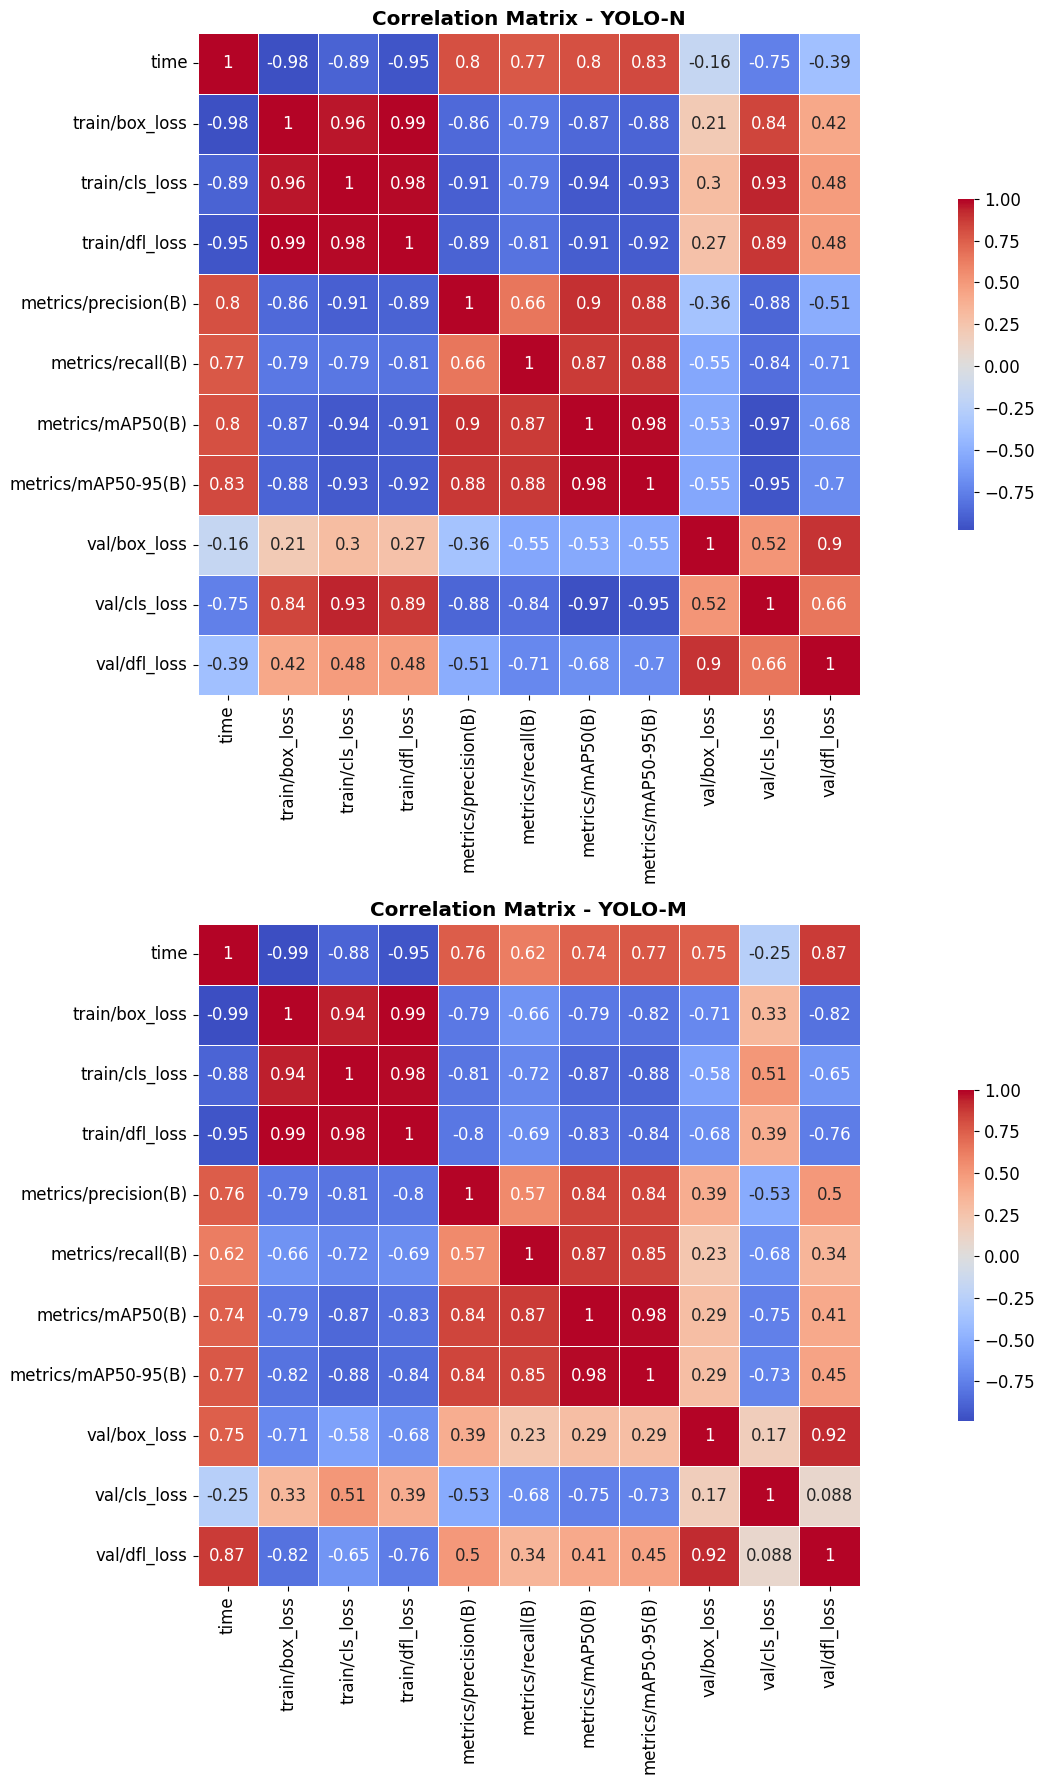

=== SIGNIFICANT CORRELATIONS (|r| > 0.7) ===

YOLO-N:
time vs train/box_loss: -0.979
time vs train/cls_loss: -0.891
time vs train/dfl_loss: -0.955
time vs metrics/precision(B): 0.802
time vs metrics/recall(B): 0.772
time vs metrics/mAP50(B): 0.803
time vs metrics/mAP50-95(B): 0.829
time vs val/cls_loss: -0.752
train/box_loss vs train/cls_loss: 0.955
train/box_loss vs train/dfl_loss: 0.988
train/box_loss vs metrics/precision(B): -0.862
train/box_loss vs metrics/recall(B): -0.790
train/box_loss vs metrics/mAP50(B): -0.868
train/box_loss vs metrics/mAP50-95(B): -0.880
train/box_loss vs val/cls_loss: 0.839
train/cls_loss vs train/dfl_loss: 0.983
train/cls_loss vs metrics/precision(B): -0.907
train/cls_loss vs metrics/recall(B): -0.794
train/cls_loss vs metrics/mAP50(B): -0.938
train/cls_loss vs metrics/mAP50-95(B): -0.932
train/cls_loss vs val/cls_loss: 0.934
train/dfl_loss vs metrics/precision(B): -0.888
train/dfl_loss vs metrics/recall(B): -0.814
train/dfl_loss vs metrics/mAP50(B): -0.91

In [38]:
# Correlation matrix for YOLO-N
plt.figure(figsize=(20, 18))
plt.subplot(2, 1, 1)
corr_matrix_n = df_yolo_n[key_metrics].corr()
sns.heatmap(corr_matrix_n, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix - YOLO-N', fontweight='bold')

# Correlation matrix for YOLO-M
plt.subplot(2, 1, 2)
corr_matrix_m = df_yolo_m[key_metrics].corr()
sns.heatmap(corr_matrix_m, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix - YOLO-M', fontweight='bold')

plt.tight_layout()
plt.show()

# Analysis of significant correlations
print("=== SIGNIFICANT CORRELATIONS (|r| > 0.7) ===")
print("\nYOLO-N:")
for i in range(len(corr_matrix_n.columns)):
    for j in range(i+1, len(corr_matrix_n.columns)):
        corr_val = corr_matrix_n.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_matrix_n.columns[i]} vs {corr_matrix_n.columns[j]}: {corr_val:.3f}")

print("\nYOLO-M:")
for i in range(len(corr_matrix_m.columns)):
    for j in range(i+1, len(corr_matrix_m.columns)):
        corr_val = corr_matrix_m.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_matrix_m.columns[i]} vs {corr_matrix_m.columns[j]}: {corr_val:.3f}")

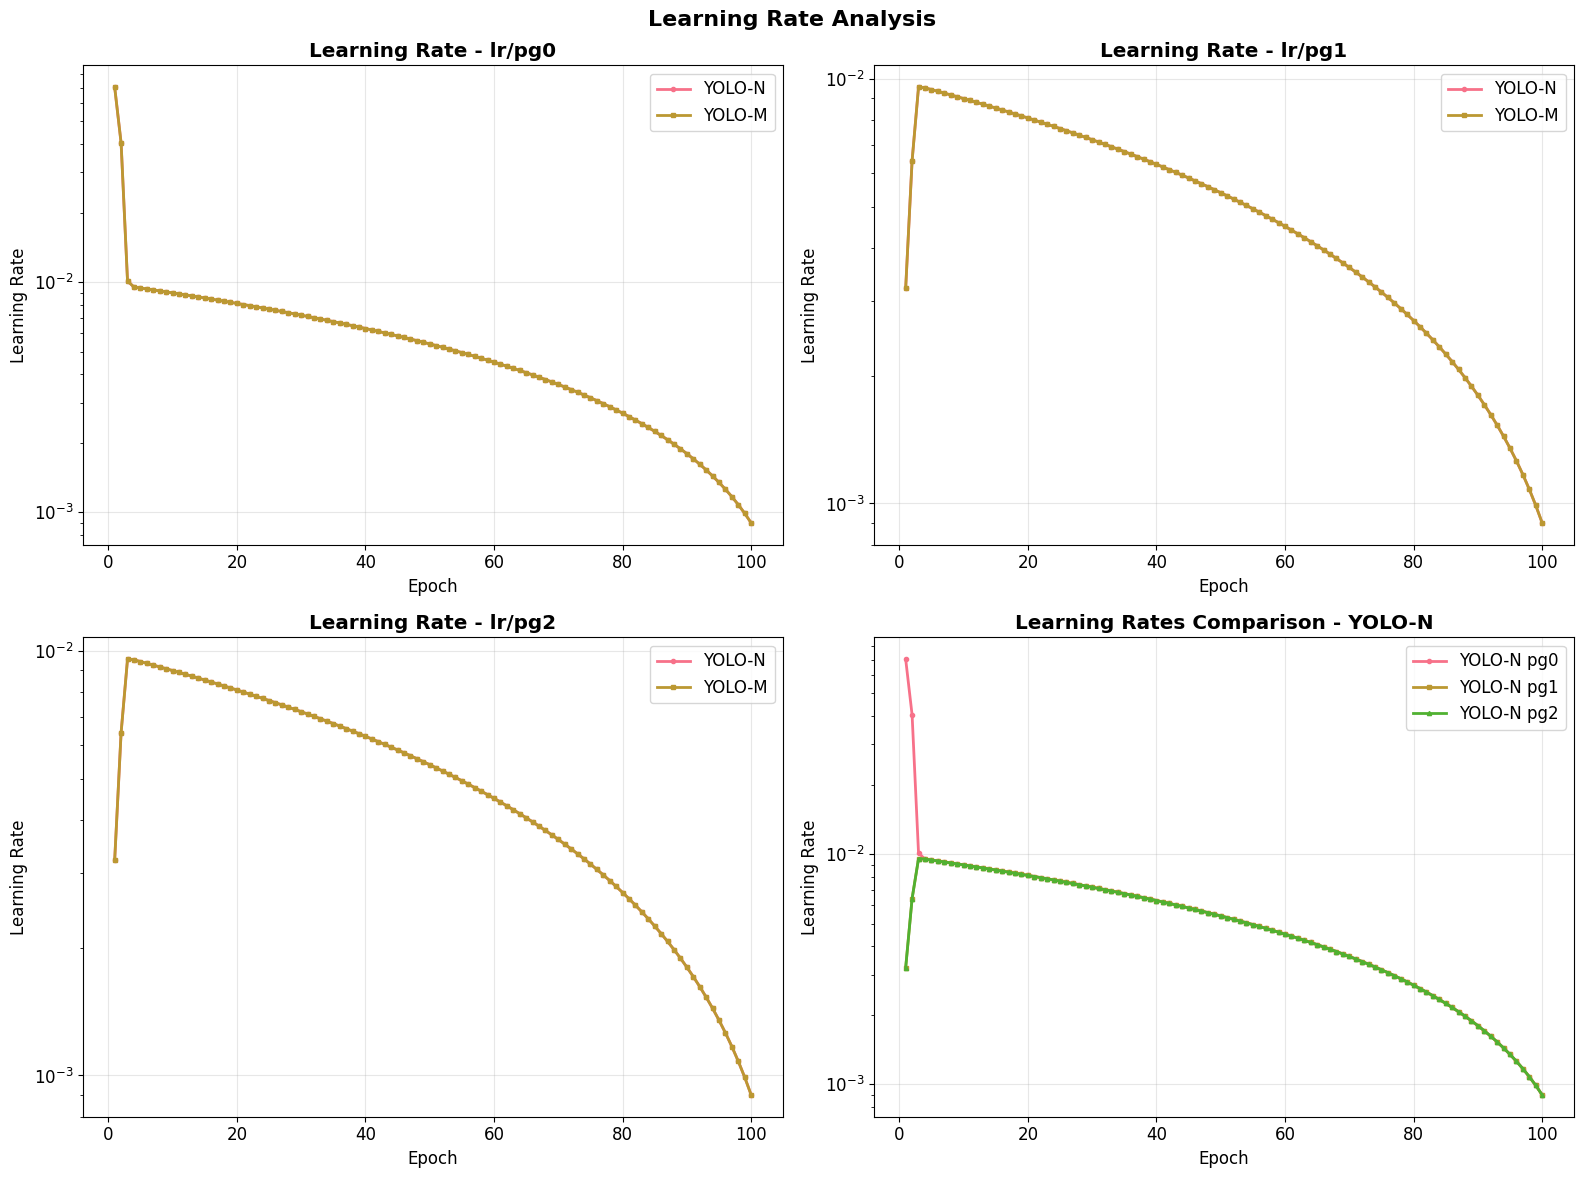

In [39]:
lr_cols = ['lr/pg0', 'lr/pg1', 'lr/pg2']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Learning Rate Analysis', fontsize=16, fontweight='bold')

# Plot of learning rates
for i, lr_col in enumerate(lr_cols):
    if i < 3:
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        ax.plot(df_yolo_n['epoch'], df_yolo_n[lr_col], 'o-', label='YOLO-N', linewidth=2, markersize=3)
        ax.plot(df_yolo_m['epoch'], df_yolo_m[lr_col], 's-', label='YOLO-M', linewidth=2, markersize=3)
        
        ax.set_title(f'Learning Rate - {lr_col}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

# Learning rates comparison for YOLO-N groups
ax = axes[1, 1]
ax.plot(df_yolo_n['epoch'], df_yolo_n['lr/pg0'], 'o-', label='YOLO-N pg0', linewidth=2, markersize=3)
ax.plot(df_yolo_n['epoch'], df_yolo_n['lr/pg1'], 's-', label='YOLO-N pg1', linewidth=2, markersize=3)
ax.plot(df_yolo_n['epoch'], df_yolo_n['lr/pg2'], '^-', label='YOLO-N pg2', linewidth=2, markersize=3)
ax.set_title('Learning Rates Comparison - YOLO-N', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

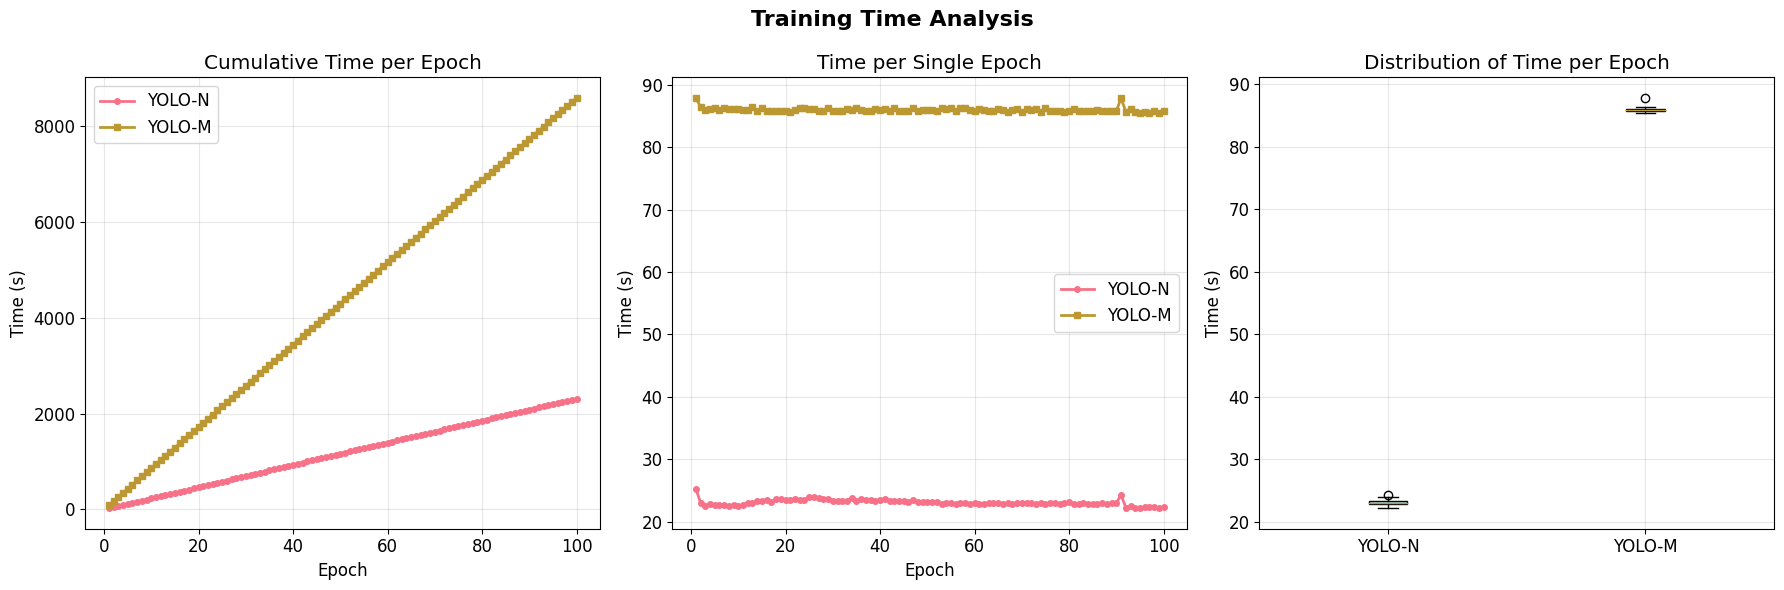

=== TRAINING TIME STATISTICS ===
YOLO-N - Total time: 2307.67s
YOLO-M - Total time: 8597.75s
YOLO-N - Average time per epoch: 23.05s
YOLO-M - Average time per epoch: 85.96s
Time ratio (M/N): 3.73


In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Training Time Analysis', fontsize=16, fontweight='bold')

# Cumulative time per epoch
axes[0].plot(df_yolo_n['epoch'], df_yolo_n['time'], 'o-', label='YOLO-N', linewidth=2, markersize=4)
axes[0].plot(df_yolo_m['epoch'], df_yolo_m['time'], 's-', label='YOLO-M', linewidth=2, markersize=4)
axes[0].set_title('Cumulative Time per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Time (s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time per single epoch (differential)
time_diff_n = np.diff(np.concatenate([[0], df_yolo_n['time'].values]))
time_diff_m = np.diff(np.concatenate([[0], df_yolo_m['time'].values]))

axes[1].plot(df_yolo_n['epoch'], time_diff_n, 'o-', label='YOLO-N', linewidth=2, markersize=4)
axes[1].plot(df_yolo_m['epoch'], time_diff_m, 's-', label='YOLO-M', linewidth=2, markersize=4)
axes[1].set_title('Time per Single Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Time (s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Boxplot of times per epoch
data_time = [time_diff_n[1:], time_diff_m[1:]]  # Exclude the first epoch
bp = axes[2].boxplot(data_time, labels=['YOLO-N', 'YOLO-M'], patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[2].set_title('Distribution of Time per Epoch')
axes[2].set_ylabel('Time (s)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training time statistics
print("=== TRAINING TIME STATISTICS ===")
print(f"YOLO-N - Total time: {df_yolo_n['time'].iloc[-1]:.2f}s")
print(f"YOLO-M - Total time: {df_yolo_m['time'].iloc[-1]:.2f}s")
print(f"YOLO-N - Average time per epoch: {np.mean(time_diff_n[1:]):.2f}s")
print(f"YOLO-M - Average time per epoch: {np.mean(time_diff_m[1:]):.2f}s")
print(f"Time ratio (M/N): {np.mean(time_diff_m[1:]) / np.mean(time_diff_n[1:]):.2f}")

In [41]:
def statistical_comparison(data1, data2, metric_name, model1_name, model2_name):
    """Performs statistical tests to compare two data series"""
    
    # Normality tests
    _, p_norm1 = stats.shapiro(data1)
    _, p_norm2 = stats.shapiro(data2)
    
    # Test for homogeneity of variances
    _, p_var = stats.levene(data1, data2)
    
    # Choose the appropriate test
    if p_norm1 > 0.05 and p_norm2 > 0.05 and p_var > 0.05:
        # Independent samples T-test
        stat, p_value = stats.ttest_ind(data1, data2)
        test_name = "Independent T-test"
    else:
        # Mann-Whitney U test (non-parametric)
        stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        test_name = "Mann-Whitney U test"
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                         (len(data2) - 1) * np.var(data2, ddof=1)) / 
                        (len(data1) + len(data2) - 2))
    cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std if pooled_std != 0 else 0
    
    return {
        'metric': metric_name,
        'test': test_name,
        'statistic': stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'cohens_d': cohens_d,
        'effect_size': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large',
        f'{model1_name}_mean': np.mean(data1),
        f'{model2_name}_mean': np.mean(data2),
        f'{model1_name}_std': np.std(data1),
        f'{model2_name}_std': np.std(data2)
    }

print("=== STATISTICAL TESTS FOR PERFORMANCE COMPARISON ===")

statistical_results = []
for metric in performance_metrics:
    result = statistical_comparison(
        df_yolo_n[metric].values, 
        df_yolo_m[metric].values, 
        metric, 
        'YOLO-N', 
        'YOLO-M'
    )
    statistical_results.append(result)

stats_df = pd.DataFrame(statistical_results)
print(stats_df.round(4))

# Interpretation of results
print("\n=== RESULTS INTERPRETATION ===")
for _, row in stats_df.iterrows():
    metric = row['metric'].replace('metrics/', '').replace('(B)', '')
    if row['significant']:
        better_model = 'YOLO-N' if row['YOLO-N_mean'] > row['YOLO-M_mean'] else 'YOLO-M'
        print(f"{metric}: {better_model} is significantly better (p={row['p_value']:.4f}, effect size: {row['effect_size']})")
    else:
        print(f"{metric}: No significant difference between models (p={row['p_value']:.4f})")

=== STATISTICAL TESTS FOR PERFORMANCE COMPARISON ===
                 metric                 test  statistic  p_value  significant  \
0  metrics/precision(B)  Mann-Whitney U test     4292.0   0.0839        False   
1     metrics/recall(B)  Mann-Whitney U test     2501.0   0.0000         True   
2      metrics/mAP50(B)  Mann-Whitney U test     2526.5   0.0000         True   
3   metrics/mAP50-95(B)  Mann-Whitney U test     2228.0   0.0000         True   

   cohens_d effect_size  YOLO-N_mean  YOLO-M_mean  YOLO-N_std  YOLO-M_std  
0   -0.2858       small       0.5858       0.6147      0.1146      0.0846  
1   -0.7999      medium       0.4906       0.5515      0.0883      0.0609  
2   -0.6775      medium       0.5095       0.5691      0.1033      0.0685  
3   -0.8035       large       0.2366       0.2759      0.0559      0.0401  

=== RESULTS INTERPRETATION ===
precision: No significant difference between models (p=0.0839)
recall: YOLO-M is significantly better (p=0.0000, effect size: med

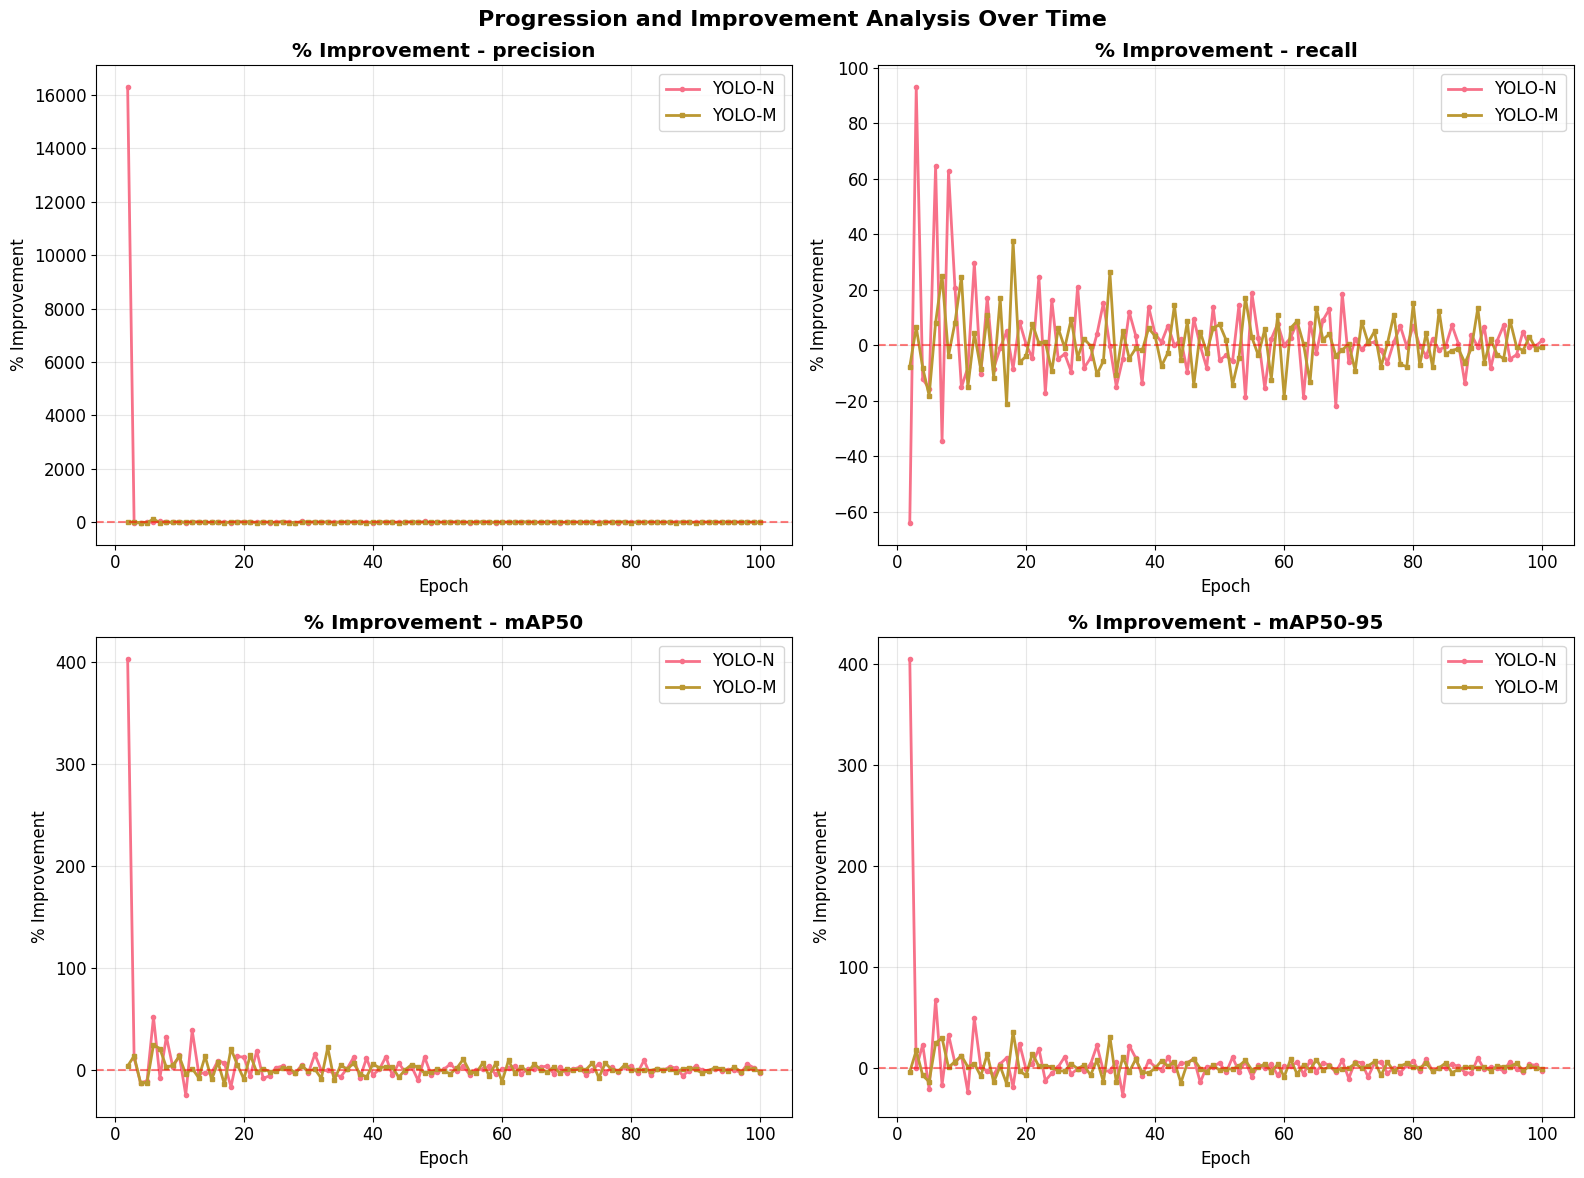

=== IMPROVEMENT STATISTICS ===

precision:
  YOLO-N - Average improvement: 165.527% (std: 1628.916%)
  YOLO-M - Average improvement: 1.580% (std: 15.385%)
  YOLO-N - Number of improvement episodes: 53/99
  YOLO-M - Number of improvement episodes: 48/99

recall:
  YOLO-N - Average improvement: 1.860% (std: 17.789%)
  YOLO-M - Average improvement: 0.759% (std: 9.934%)
  YOLO-N - Number of improvement episodes: 49/99
  YOLO-M - Number of improvement episodes: 48/99

mAP50:
  YOLO-N - Average improvement: 5.445% (std: 41.309%)
  YOLO-M - Average improvement: 0.819% (std: 6.931%)
  YOLO-N - Number of improvement episodes: 51/99
  YOLO-M - Number of improvement episodes: 53/99

mAP50-95:
  YOLO-N - Average improvement: 5.994% (std: 42.208%)
  YOLO-M - Average improvement: 1.080% (std: 8.539%)
  YOLO-N - Number of improvement episodes: 54/99
  YOLO-M - Number of improvement episodes: 54/99


In [42]:
# Calculate improvement per epoch
def calculate_improvement(df, metric):
    """Calculates the percentage improvement per epoch"""
    values = df[metric].values
    if len(values) < 2:
        return np.array([0])
    
    improvements = []
    for i in range(1, len(values)):
        if values[i-1] != 0:
            improvement = ((values[i] - values[i-1]) / abs(values[i-1])) * 100
            improvements.append(improvement)
        else:
            improvements.append(0)
    
    return np.array(improvements)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Progression and Improvement Analysis Over Time', fontsize=16, fontweight='bold')

for i, metric in enumerate(performance_metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Calculate improvements
    improvements_n = calculate_improvement(df_yolo_n, metric)
    improvements_m = calculate_improvement(df_yolo_m, metric)
    
    if len(improvements_n) > 0 and len(improvements_m) > 0:
        epochs_n = df_yolo_n['epoch'].values[1:]
        epochs_m = df_yolo_m['epoch'].values[1:]
        
        ax.plot(epochs_n, improvements_n, 'o-', label='YOLO-N', linewidth=2, markersize=3)
        ax.plot(epochs_m, improvements_m, 's-', label='YOLO-M', linewidth=2, markersize=3)
        
        # Zero reference line
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        ax.set_title(f'% Improvement - {metric.replace("metrics/", "").replace("(B)", "")}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('% Improvement')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Improvement statistics
print("=== IMPROVEMENT STATISTICS ===")
for metric in performance_metrics:
    improvements_n = calculate_improvement(df_yolo_n, metric)
    improvements_m = calculate_improvement(df_yolo_m, metric)
    
    if len(improvements_n) > 0 and len(improvements_m) > 0:
        metric_clean = metric.replace('metrics/', '').replace('(B)', '')
        print(f"\n{metric_clean}:")
        print(f"  YOLO-N - Average improvement: {np.mean(improvements_n):.3f}% (std: {np.std(improvements_n):.3f}%)")
        print(f"  YOLO-M - Average improvement: {np.mean(improvements_m):.3f}% (std: {np.std(improvements_m):.3f}%)")
        print(f"  YOLO-N - Number of improvement episodes: {np.sum(improvements_n > 0)}/{len(improvements_n)}")
        print(f"  YOLO-M - Number of improvement episodes: {np.sum(improvements_m > 0)}/{len(improvements_m)}")

=== EFFICIENCY ANALYSIS ===
    model  final_mAP50  final_mAP50-95  total_time  avg_time_per_epoch  \
0  YOLO-N      0.58462         0.27682     2307.67             23.0767   
1  YOLO-M      0.60774         0.30787     8597.75             85.9775   

   efficiency_mAP50_total  efficiency_mAP50-95_total  \
0                0.000253                   0.000120   
1                0.000071                   0.000036   

   efficiency_mAP50_per_epoch  efficiency_mAP50-95_per_epoch  
0                    0.025334                       0.011996  
1                    0.007069                       0.003581  


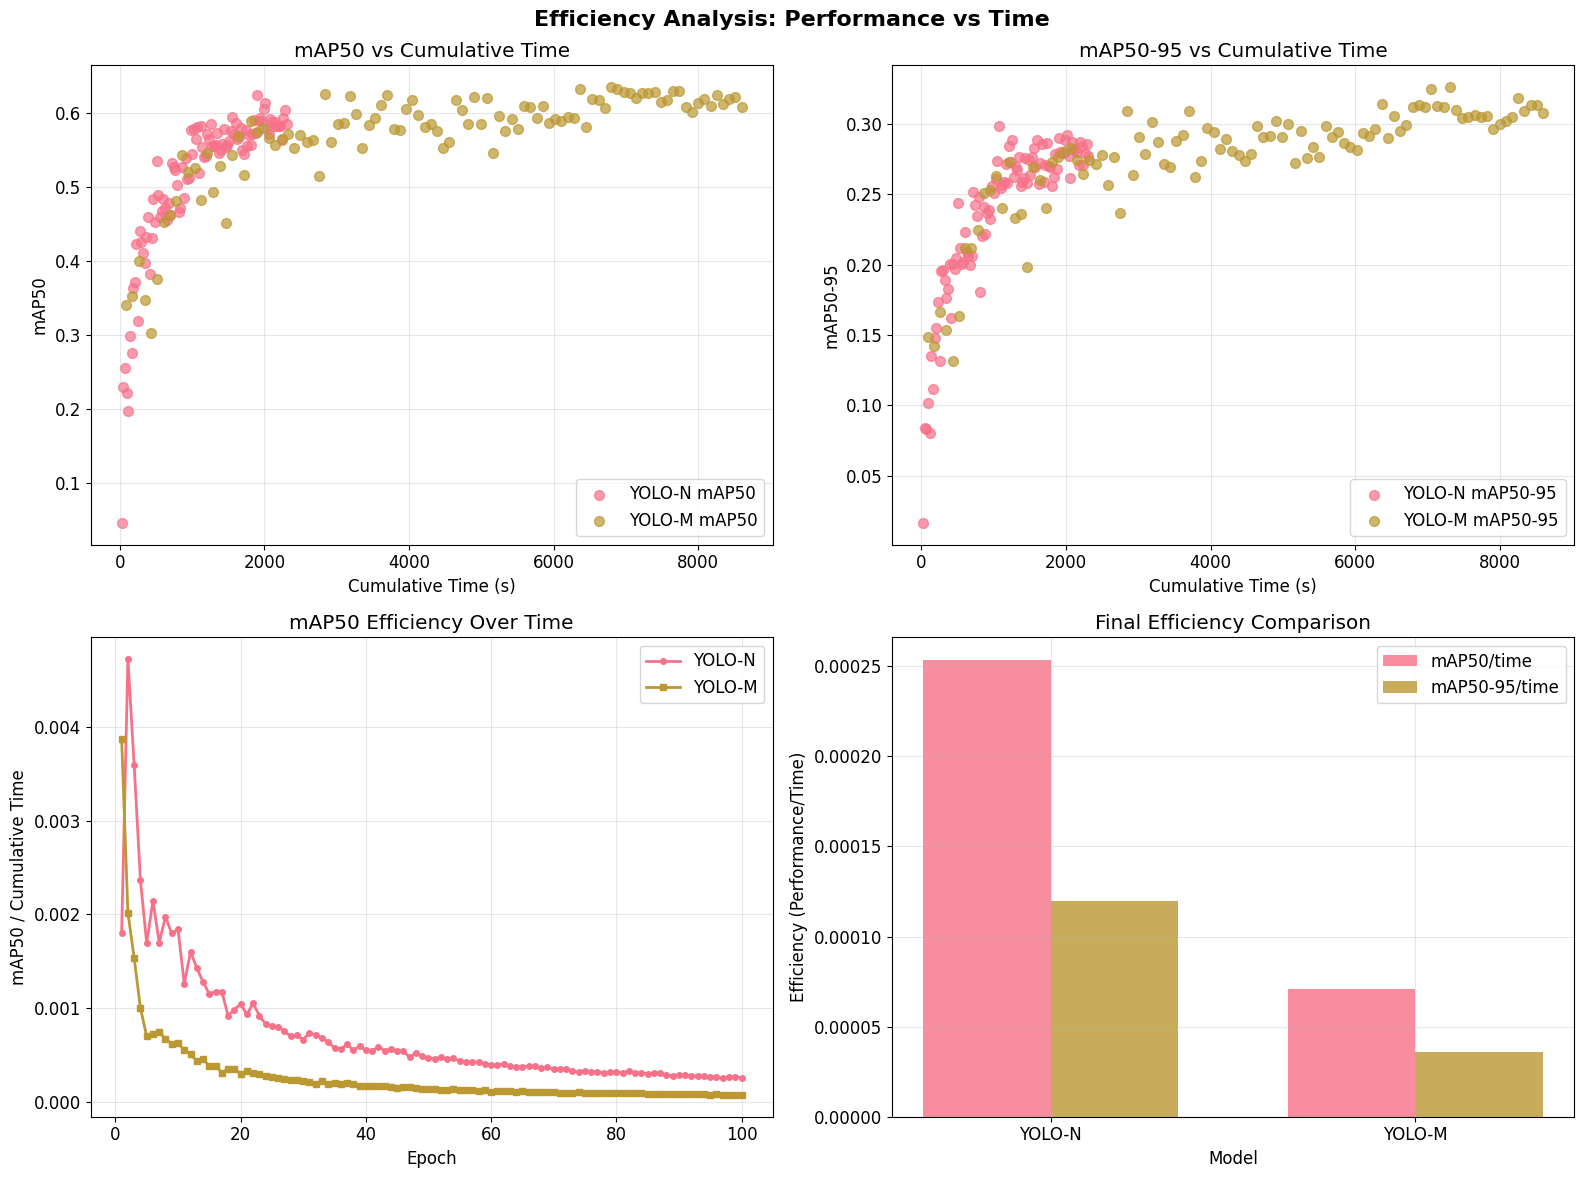

In [43]:
# Calculate efficiency as performance/time ratio
def calculate_efficiency_metrics(df, model_name):
    """Calculates efficiency metrics"""
    final_map50 = df['metrics/mAP50(B)'].iloc[-1]
    final_map5095 = df['metrics/mAP50-95(B)'].iloc[-1]
    total_time = df['time'].iloc[-1]
    
    # Time efficiency
    efficiency_map50 = final_map50 / total_time if total_time > 0 else 0
    efficiency_map5095 = final_map5095 / total_time if total_time > 0 else 0
    
    # Efficiency per epoch
    avg_time_per_epoch = total_time / len(df) if len(df) > 0 else 0
    efficiency_per_epoch_map50 = final_map50 / avg_time_per_epoch if avg_time_per_epoch > 0 else 0
    efficiency_per_epoch_map5095 = final_map5095 / avg_time_per_epoch if avg_time_per_epoch > 0 else 0
    
    return {
        'model': model_name,
        'final_mAP50': final_map50,
        'final_mAP50-95': final_map5095,
        'total_time': total_time,
        'avg_time_per_epoch': avg_time_per_epoch,
        'efficiency_mAP50_total': efficiency_map50,
        'efficiency_mAP50-95_total': efficiency_map5095,
        'efficiency_mAP50_per_epoch': efficiency_per_epoch_map50,
        'efficiency_mAP50-95_per_epoch': efficiency_per_epoch_map5095
    }

efficiency_n = calculate_efficiency_metrics(df_yolo_n, 'YOLO-N')
efficiency_m = calculate_efficiency_metrics(df_yolo_m, 'YOLO-M')

efficiency_df = pd.DataFrame([efficiency_n, efficiency_m])

print("=== EFFICIENCY ANALYSIS ===")
print(efficiency_df.round(6))

# Efficiency visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Efficiency Analysis: Performance vs Time', fontsize=16, fontweight='bold')

# Performance vs Total Time
axes[0, 0].scatter(df_yolo_n['time'], df_yolo_n['metrics/mAP50(B)'], 
                   label='YOLO-N mAP50', alpha=0.7, s=50)
axes[0, 0].scatter(df_yolo_m['time'], df_yolo_m['metrics/mAP50(B)'], 
                   label='YOLO-M mAP50', alpha=0.7, s=50)
axes[0, 0].set_xlabel('Cumulative Time (s)')
axes[0, 0].set_ylabel('mAP50')
axes[0, 0].set_title('mAP50 vs Cumulative Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance vs Total Time for mAP50-95
axes[0, 1].scatter(df_yolo_n['time'], df_yolo_n['metrics/mAP50-95(B)'], 
                   label='YOLO-N mAP50-95', alpha=0.7, s=50)
axes[0, 1].scatter(df_yolo_m['time'], df_yolo_m['metrics/mAP50-95(B)'], 
                   label='YOLO-M mAP50-95', alpha=0.7, s=50)
axes[0, 1].set_xlabel('Cumulative Time (s)')
axes[0, 1].set_ylabel('mAP50-95')
axes[0, 1].set_title('mAP50-95 vs Cumulative Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Efficiency over time for mAP50
time_diff_n = np.diff(np.concatenate([[0], df_yolo_n['time'].values]))
time_diff_m = np.diff(np.concatenate([[0], df_yolo_m['time'].values]))

efficiency_timeline_n = df_yolo_n['metrics/mAP50(B)'] / df_yolo_n['time']
efficiency_timeline_m = df_yolo_m['metrics/mAP50(B)'] / df_yolo_m['time']

axes[1, 0].plot(df_yolo_n['epoch'], efficiency_timeline_n, 'o-', 
                label='YOLO-N', linewidth=2, markersize=4)
axes[1, 0].plot(df_yolo_m['epoch'], efficiency_timeline_m, 's-', 
                label='YOLO-M', linewidth=2, markersize=4)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('mAP50 / Cumulative Time')
axes[1, 0].set_title('mAP50 Efficiency Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final efficiency comparison
models = ['YOLO-N', 'YOLO-M']
efficiency_map50 = [efficiency_n['efficiency_mAP50_total'], efficiency_m['efficiency_mAP50_total']]
efficiency_map5095 = [efficiency_n['efficiency_mAP50-95_total'], efficiency_m['efficiency_mAP50-95_total']]

x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, efficiency_map50, width, label='mAP50/time', alpha=0.8)
axes[1, 1].bar(x + width/2, efficiency_map5095, width, label='mAP50-95/time', alpha=0.8)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Efficiency (Performance/Time)')
axes[1, 1].set_title('Final Efficiency Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== OVERFITTING AND GENERALIZATION ANALYSIS ===
    model  avg_box_gap  avg_cls_gap  avg_dfl_gap  train_box_trend  \
0  YOLO-N      -0.2016      -0.3440      -0.1973          -0.0085   
1  YOLO-M      -0.6365      -0.8209      -0.4749          -0.0136   

   val_box_trend  val_loss_stability  performance_stability  final_box_gap  \
0        -0.0005              0.0401                 0.0171        -0.7599   
1         0.0020              0.0266                 0.0145        -1.4047   

   final_performance  
0             0.5846  
1             0.6077  


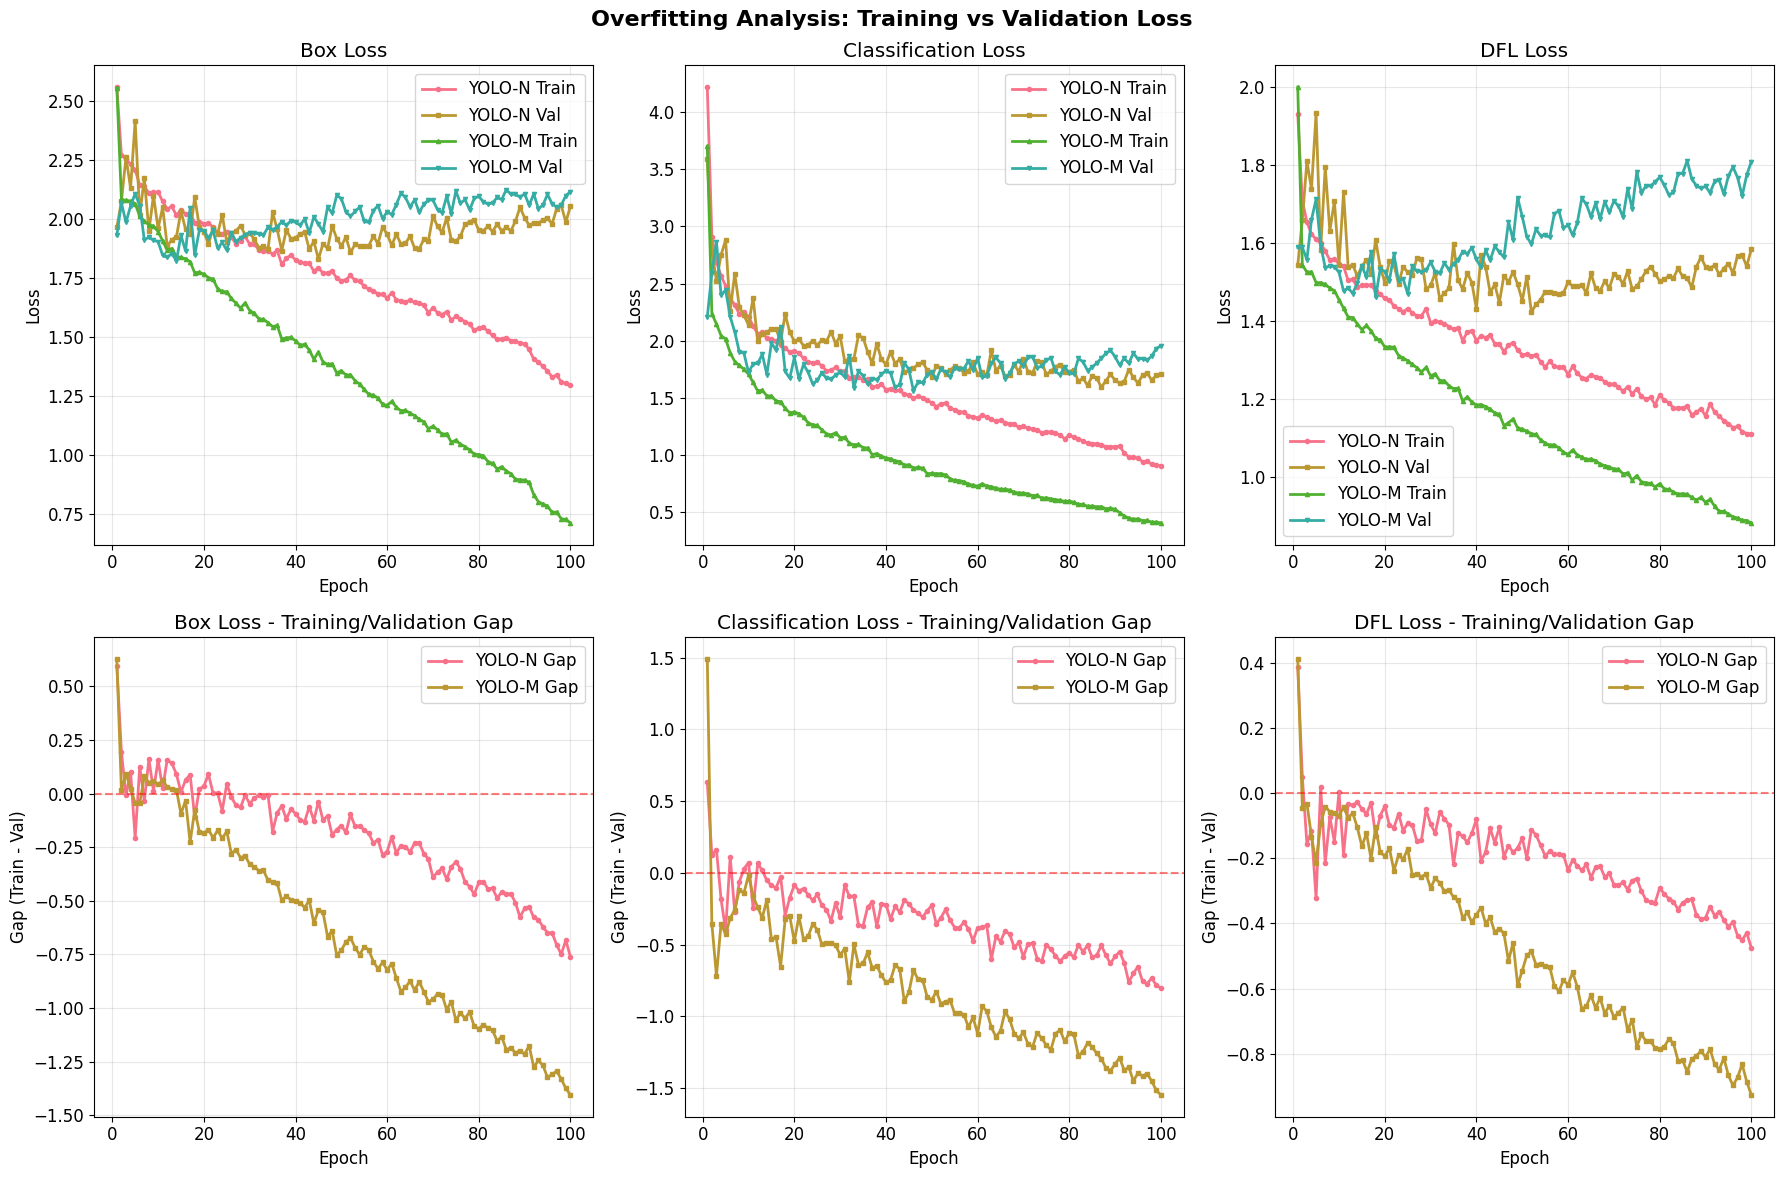


=== OVERFITTING INTERPRETATION ===

YOLO-N:
  ✅ Final box loss gap acceptable: -0.7599
  ⚠️  Training loss is decreasing faster than validation loss
  ⚠️  Unstable performance in the last epochs (std: 0.0171)

YOLO-M:
  ✅ Final box loss gap acceptable: -1.4047
  ⚠️  Training loss is decreasing faster than validation loss
  ⚠️  Unstable performance in the last epochs (std: 0.0145)


In [44]:
# Calculate training-validation gap for losses
def calculate_overfitting_metrics(df, model_name):
    """Calculates metrics to identify overfitting"""
    
    # Gap between training and validation loss
    box_gap = df['train/box_loss'] - df['val/box_loss']
    cls_gap = df['train/cls_loss'] - df['val/cls_loss']
    dfl_gap = df['train/dfl_loss'] - df['val/dfl_loss']
    
    # Loss trends
    train_box_trend = np.polyfit(range(len(df)), df['train/box_loss'], 1)[0]
    val_box_trend = np.polyfit(range(len(df)), df['val/box_loss'], 1)[0]
    
    # Stability in the last epochs (last 30% of data)
    last_portion = max(3, len(df) // 3)
    last_epochs = df.tail(last_portion)
    
    val_stability = np.std(last_epochs['val/box_loss'])
    performance_stability = np.std(last_epochs['metrics/mAP50(B)'])
    
    return {
        'model': model_name,
        'avg_box_gap': np.mean(box_gap),
        'avg_cls_gap': np.mean(cls_gap),
        'avg_dfl_gap': np.mean(dfl_gap),
        'train_box_trend': train_box_trend,
        'val_box_trend': val_box_trend,
        'val_loss_stability': val_stability,
        'performance_stability': performance_stability,
        'final_box_gap': box_gap.iloc[-1],
        'final_performance': df['metrics/mAP50(B)'].iloc[-1]
    }

overfitting_n = calculate_overfitting_metrics(df_yolo_n, 'YOLO-N')
overfitting_m = calculate_overfitting_metrics(df_yolo_m, 'YOLO-M')

overfitting_df = pd.DataFrame([overfitting_n, overfitting_m])

print("=== OVERFITTING AND GENERALIZATION ANALYSIS ===")
print(overfitting_df.round(4))

# Overfitting visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Overfitting Analysis: Training vs Validation Loss', fontsize=16, fontweight='bold')

loss_types = [('box_loss', 'Box Loss'), ('cls_loss', 'Classification Loss'), ('dfl_loss', 'DFL Loss')]

for i, (loss_type, title) in enumerate(loss_types):
    # Training vs Validation Loss
    ax = axes[0, i]
    ax.plot(df_yolo_n['epoch'], df_yolo_n[f'train/{loss_type}'], 'o-', 
            label='YOLO-N Train', linewidth=2, markersize=3)
    ax.plot(df_yolo_n['epoch'], df_yolo_n[f'val/{loss_type}'], 's-', 
            label='YOLO-N Val', linewidth=2, markersize=3)
    ax.plot(df_yolo_m['epoch'], df_yolo_m[f'train/{loss_type}'], '^-', 
            label='YOLO-M Train', linewidth=2, markersize=3)
    ax.plot(df_yolo_m['epoch'], df_yolo_m[f'val/{loss_type}'], 'v-', 
            label='YOLO-M Val', linewidth=2, markersize=3)
    
    ax.set_title(f'{title}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Gap Analysis
    ax = axes[1, i]
    gap_n = df_yolo_n[f'train/{loss_type}'] - df_yolo_n[f'val/{loss_type}']
    gap_m = df_yolo_m[f'train/{loss_type}'] - df_yolo_m[f'val/{loss_type}']
    
    ax.plot(df_yolo_n['epoch'], gap_n, 'o-', label='YOLO-N Gap', linewidth=2, markersize=3)
    ax.plot(df_yolo_m['epoch'], gap_m, 's-', label='YOLO-M Gap', linewidth=2, markersize=3)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{title} - Training/Validation Gap')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gap (Train - Val)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overfitting interpretation
print("\n=== OVERFITTING INTERPRETATION ===")
for _, row in overfitting_df.iterrows():
    model = row['model']
    print(f"\n{model}:")
    
    # Final gap evaluation
    if row['final_box_gap'] > 0.1:
        print(f"  ⚠️  Possible overfitting: final box loss gap = {row['final_box_gap']:.4f}")
    else:
        print(f"  ✅ Final box loss gap acceptable: {row['final_box_gap']:.4f}")
    
    # Trend evaluation
    if row['train_box_trend'] < row['val_box_trend']:
        print(f"  ⚠️  Training loss is decreasing faster than validation loss")
    else:
        print(f"  ✅ Balanced learning trend")
    
    # Stability evaluation
    if row['performance_stability'] < 0.01:
        print(f"  ✅ Stable performance in the last epochs (std: {row['performance_stability']:.4f})")
    else:
        print(f"  ⚠️  Unstable performance in the last epochs (std: {row['performance_stability']:.4f})")


=== ROBUSTNESS AND CONSISTENCY ANALYSIS ===

Coefficient of Variation (lower = more stable):
    model  cv_metrics/precision(B)  cv_metrics/recall(B)  cv_metrics/mAP50(B)  \
0  YOLO-N                   0.1966                0.1809               0.2037   
1  YOLO-M                   0.1383                0.1110               0.1209   

   cv_metrics/mAP50-95(B)  
0                  0.2375  
1                  0.1461  

Performance Range (lower = more consistent):
    model  range_metrics/precision(B)  range_metrics/recall(B)  \
0  YOLO-N                      0.7407                   0.4738   
1  YOLO-M                      0.4851                   0.3128   

   range_metrics/mAP50(B)  range_metrics/mAP50-95(B)  
0                  0.5782                     0.2815  
1                  0.3329                     0.1943  

Improvement Rate (higher = more positive trend):
    model  improvement_rate_metrics/precision(B)  \
0  YOLO-N                                 0.5354   
1  YOLO-M      

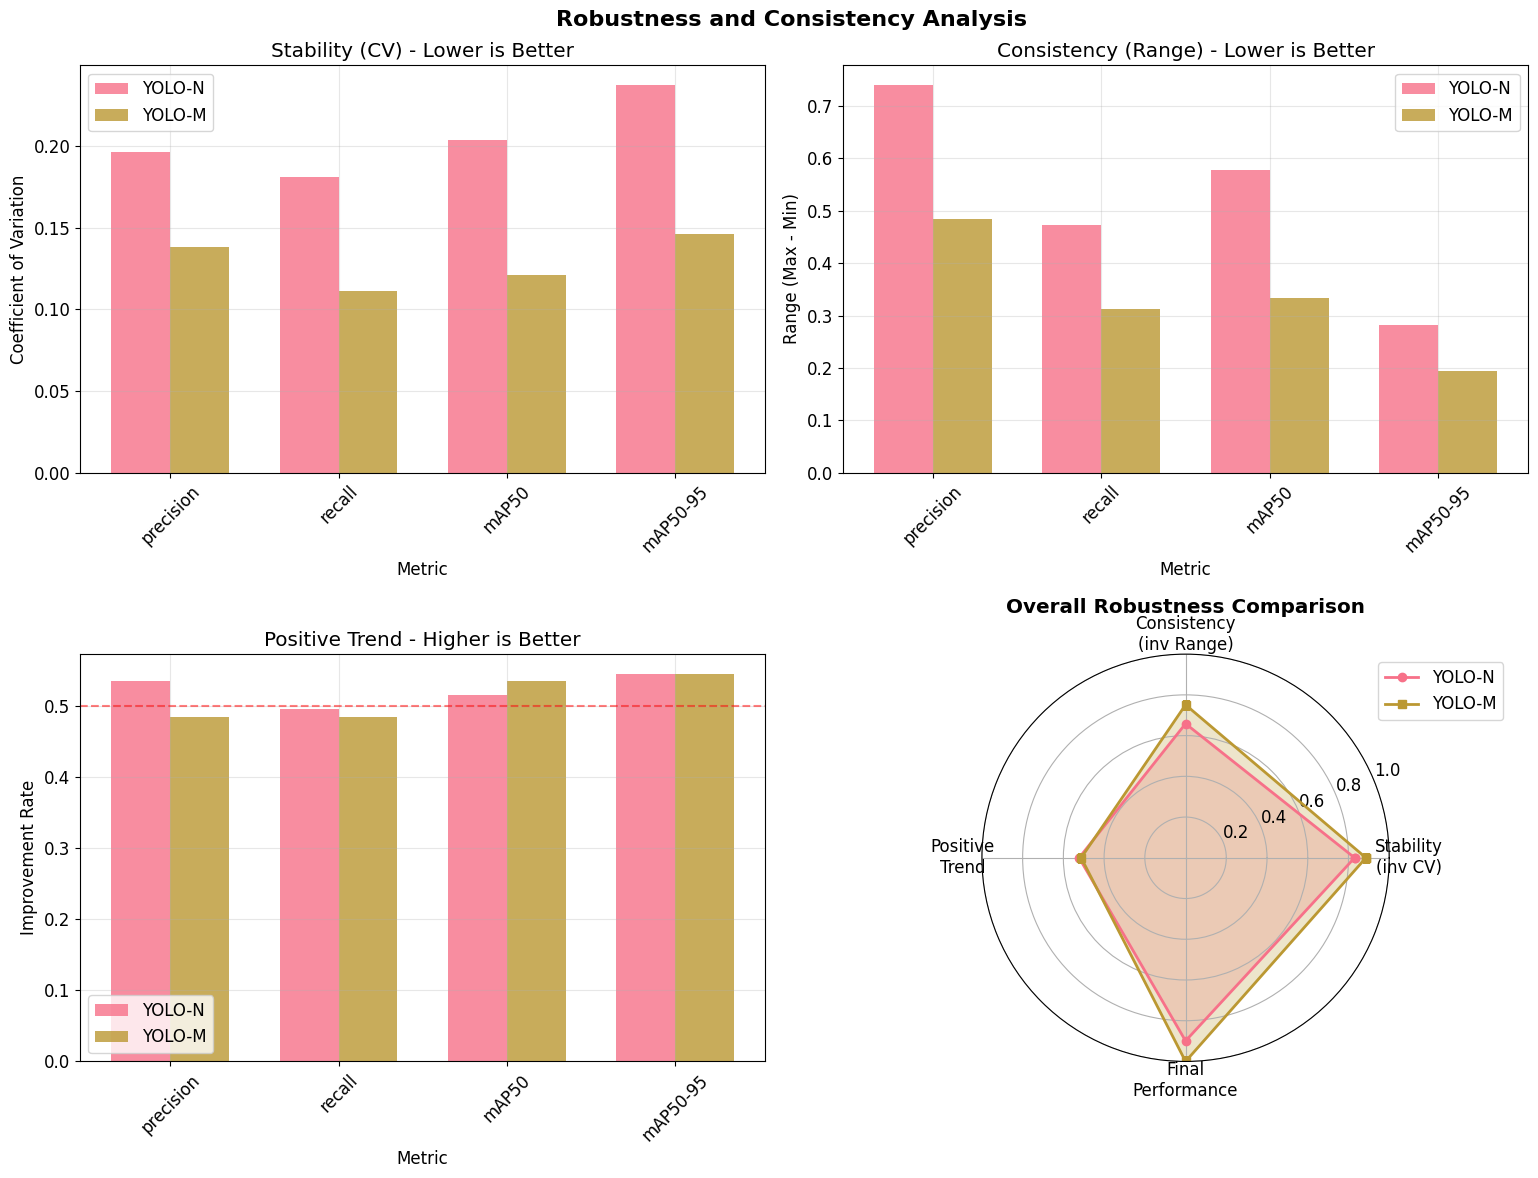

In [45]:
def calculate_robustness_metrics(df, model_name):
    """Calculates robustness and consistency metrics"""
    
    # Coefficient of variation for key metrics
    cv_metrics = {}
    for metric in performance_metrics:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        cv_metrics[f'cv_{metric}'] = std_val / mean_val if mean_val != 0 else np.inf
    
    # Performance range
    range_metrics = {}
    for metric in performance_metrics:
        range_metrics[f'range_{metric}'] = df[metric].max() - df[metric].min()
    
    # Monotonicity (overall increasing/decreasing trend)
    monotonicity = {}
    for metric in performance_metrics:
        values = df[metric].values
        if len(values) > 1:
            # Calculate consecutive differences
            diffs = np.diff(values)
            # Percentage of improvements
            improvements = np.sum(diffs > 0) / len(diffs)
            monotonicity[f'improvement_rate_{metric}'] = improvements
    
    result = {'model': model_name}
    result.update(cv_metrics)
    result.update(range_metrics)
    result.update(monotonicity)
    
    return result

robustness_n = calculate_robustness_metrics(df_yolo_n, 'YOLO-N')
robustness_m = calculate_robustness_metrics(df_yolo_m, 'YOLO-M')

# Robustness comparison
robustness_comparison = pd.DataFrame([robustness_n, robustness_m])

print("=== ROBUSTNESS AND CONSISTENCY ANALYSIS ===")

# Extract relevant metrics for visualization
cv_cols = [col for col in robustness_comparison.columns if col.startswith('cv_')]
range_cols = [col for col in robustness_comparison.columns if col.startswith('range_')]
improvement_cols = [col for col in robustness_comparison.columns if col.startswith('improvement_rate_')]

print("\nCoefficient of Variation (lower = more stable):")
cv_data = robustness_comparison[['model'] + cv_cols]
print(cv_data.round(4))

print("\nPerformance Range (lower = more consistent):")
range_data = robustness_comparison[['model'] + range_cols]
print(range_data.round(4))

print("\nImprovement Rate (higher = more positive trend):")
improvement_data = robustness_comparison[['model'] + improvement_cols]
print(improvement_data.round(4))

# Robustness visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Robustness and Consistency Analysis', fontsize=16, fontweight='bold')

# Coefficients of Variation
metric_names = [col.replace('cv_metrics/', '').replace('(B)', '') for col in cv_cols]
cv_n = [robustness_n[col] for col in cv_cols]
cv_m = [robustness_m[col] for col in cv_cols]

x = np.arange(len(metric_names))
width = 0.35

axes[0, 0].bar(x - width/2, cv_n, width, label='YOLO-N', alpha=0.8)
axes[0, 0].bar(x + width/2, cv_m, width, label='YOLO-M', alpha=0.8)
axes[0, 0].set_xlabel('Metric')
axes[0, 0].set_ylabel('Coefficient of Variation')
axes[0, 0].set_title('Stability (CV) - Lower is Better')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metric_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Performance Range
range_names = [col.replace('range_metrics/', '').replace('(B)', '') for col in range_cols]
range_n = [robustness_n[col] for col in range_cols]
range_m = [robustness_m[col] for col in range_cols]

axes[0, 1].bar(x - width/2, range_n, width, label='YOLO-N', alpha=0.8)
axes[0, 1].bar(x + width/2, range_m, width, label='YOLO-M', alpha=0.8)
axes[0, 1].set_xlabel('Metric')
axes[0, 1].set_ylabel('Range (Max - Min)')
axes[0, 1].set_title('Consistency (Range) - Lower is Better')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(range_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Improvement Rate
improvement_names = [col.replace('improvement_rate_metrics/', '').replace('(B)', '') for col in improvement_cols]
improvement_n = [robustness_n[col] for col in improvement_cols]
improvement_m = [robustness_m[col] for col in improvement_cols]

axes[1, 0].bar(x - width/2, improvement_n, width, label='YOLO-N', alpha=0.8)
axes[1, 0].bar(x + width/2, improvement_m, width, label='YOLO-M', alpha=0.8)
axes[1, 0].set_xlabel('Metric')
axes[1, 0].set_ylabel('Improvement Rate')
axes[1, 0].set_title('Positive Trend - Higher is Better')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(improvement_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')

# Radar chart for overall comparison
categories = ['Stability\n(inv CV)', 'Consistency\n(inv Range)', 'Positive\nTrend', 'Final\nPerformance']

# Normalize values for radar chart
stability_n = 1 / (1 + np.mean(cv_n))  # Inverse of mean CV
stability_m = 1 / (1 + np.mean(cv_m))

consistency_n = 1 / (1 + np.mean(range_n))  # Inverse of mean range
consistency_m = 1 / (1 + np.mean(range_m))

trend_n = np.mean(improvement_n)
trend_m = np.mean(improvement_m)

performance_n = df_yolo_n['metrics/mAP50-95(B)'].iloc[-1]
performance_m = df_yolo_m['metrics/mAP50-95(B)'].iloc[-1]
max_performance = max(performance_n, performance_m)
performance_n_norm = performance_n / max_performance if max_performance > 0 else 0
performance_m_norm = performance_m / max_performance if max_performance > 0 else 0

values_n = [stability_n, consistency_n, trend_n, performance_n_norm]
values_m = [stability_m, consistency_m, trend_m, performance_m_norm]

# Close the radar chart loop
values_n += values_n[:1]
values_m += values_m[:1]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = axes[1, 1]
ax = plt.subplot(224, projection='polar')
ax.plot(angles, values_n, 'o-', linewidth=2, label='YOLO-N')
ax.fill(angles, values_n, alpha=0.25)
ax.plot(angles, values_m, 's-', linewidth=2, label='YOLO-M')
ax.fill(angles, values_m, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Overall Robustness Comparison', y=1.08, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

In [51]:
# ==================================================
#                      FINAL REPORT
#               COMPARISON: YOLO-N vs YOLO-M
# ==================================================

print("="*70)
print("                          FINAL REPORT")
print("                 COMPARISON: YOLO-N vs YOLO-M")
print("="*70)

# 0. Calcolo F1 Score
df_yolo_n['F1'] = 2 * (df_yolo_n['metrics/precision(B)'] * df_yolo_n['metrics/recall(B)']) / \
                  (df_yolo_n['metrics/precision(B)'] + df_yolo_n['metrics/recall(B)'])
df_yolo_m['F1'] = 2 * (df_yolo_m['metrics/precision(B)'] * df_yolo_m['metrics/recall(B)']) / \
                  (df_yolo_m['metrics/precision(B)'] + df_yolo_m['metrics/recall(B)'])

# 1. Final metrics (last run)
final_metrics_n = {
    'mAP50': df_yolo_n['metrics/mAP50(B)'].iloc[-1],
    'mAP50-95': df_yolo_n['metrics/mAP50-95(B)'].iloc[-1],
    'Precision': df_yolo_n['metrics/precision(B)'].iloc[-1],
    'Recall': df_yolo_n['metrics/recall(B)'].iloc[-1],
    'F1': df_yolo_n['F1'].iloc[-1],
    'Total_time': df_yolo_n['time'].iloc[-1],
    'Epochs': len(df_yolo_n)
}

final_metrics_m = {
    'mAP50': df_yolo_m['metrics/mAP50(B)'].iloc[-1],
    'mAP50-95': df_yolo_m['metrics/mAP50-95(B)'].iloc[-1],
    'Precision': df_yolo_m['metrics/precision(B)'].iloc[-1],
    'Recall': df_yolo_m['metrics/recall(B)'].iloc[-1],
    'F1': df_yolo_m['F1'].iloc[-1],
    'Total_time': df_yolo_m['time'].iloc[-1],
    'Epochs': len(df_yolo_m)
}

print("\n1. FINAL PERFORMANCE (LAST RUN):")
print("-" * 40)
for metric in ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1']:
    val_n = final_metrics_n[metric]
    val_m = final_metrics_m[metric]
    better = "YOLO-M" if val_m > val_n else "YOLO-N"
    diff = abs(val_m - val_n)
    diff_pct = (diff / max(val_n, val_m)) * 100 if max(val_n, val_m) > 0 else 0
    print(f"{metric:12}: YOLO-N={val_n:.4f}, YOLO-M={val_m:.4f} → {better} (+{diff_pct:.1f}%)")

# 1B. Best checkpoint for each metric
best_metrics_n = {}
best_metrics_m = {}

for metric in ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)', 'F1']:
    idx_n = df_yolo_n[metric].idxmax()
    idx_m = df_yolo_m[metric].idxmax()
    best_metrics_n[metric] = (df_yolo_n[metric].iloc[idx_n], idx_n)
    best_metrics_m[metric] = (df_yolo_m[metric].iloc[idx_m], idx_m)

print("\n1B. BEST PERFORMANCE PER METRIC:")
print("-" * 40)
metric_names = {
    'metrics/mAP50(B)': 'mAP50',
    'metrics/mAP50-95(B)': 'mAP50-95',
    'metrics/precision(B)': 'Precision',
    'metrics/recall(B)': 'Recall',
    'F1': 'F1 Score'
}
for metric in best_metrics_n:
    val_n, ep_n = best_metrics_n[metric]
    val_m, ep_m = best_metrics_m[metric]
    better = "YOLO-M" if val_m > val_n else "YOLO-N"
    diff = abs(val_m - val_n)
    diff_pct = (diff / max(val_n, val_m)) * 100 if max(val_n, val_m) > 0 else 0
    print(f"{metric_names[metric]:12}: YOLO-N={val_n:.4f} (ep {ep_n}), YOLO-M={val_m:.4f} (ep {ep_m}) → {better} (+{diff_pct:.1f}%)")

# BEST Table
best_table = pd.DataFrame({
    "mAP50": [best_metrics_n["metrics/mAP50(B)"][0], best_metrics_m["metrics/mAP50(B)"][0]],
    "mAP50-95": [best_metrics_n["metrics/mAP50-95(B)"][0], best_metrics_m["metrics/mAP50-95(B)"][0]],
    "Precision": [best_metrics_n["metrics/precision(B)"][0], best_metrics_m["metrics/precision(B)"][0]],
    "Recall": [best_metrics_n["metrics/recall(B)"][0], best_metrics_m["metrics/recall(B)"][0]],
    "F1 Score": [best_metrics_n["F1"][0], best_metrics_m["F1"][0]],
}, index=["YOLO-N (best)", "YOLO-M (best)"])

# LAST Table
last_table = pd.DataFrame({
    "mAP50": [final_metrics_n["mAP50"], final_metrics_m["mAP50"]],
    "mAP50-95": [final_metrics_n["mAP50-95"], final_metrics_m["mAP50-95"]],
    "Precision": [final_metrics_n["Precision"], final_metrics_m["Precision"]],
    "Recall": [final_metrics_n["Recall"], final_metrics_m["Recall"]],
    "F1 Score": [final_metrics_n["F1"], final_metrics_m["F1"]],
}, index=["YOLO-N (last)", "YOLO-M (last)"])

print("\n📊 BEST METRICS TABLE (2 rows, 5 columns):")
print(best_table.round(4))

print("\n📊 LAST METRICS TABLE (2 rows, 5 columns):")
print(last_table.round(4))

# 2. Time efficiency
print(f"\n2. TIME EFFICIENCY:")
print("-" * 40)
print(f"Total time     : YOLO-N={final_metrics_n['Total_time']:.1f}s, YOLO-M={final_metrics_m['Total_time']:.1f}s")
print(f"Time per epoch : YOLO-N={final_metrics_n['Total_time']/final_metrics_n['Epochs']:.1f}s, YOLO-M={final_metrics_m['Total_time']/final_metrics_m['Epochs']:.1f}s")
print(f"Efficiency     : YOLO-N={efficiency_n['efficiency_mAP50-95_total']:.6f}, YOLO-M={efficiency_m['efficiency_mAP50-95_total']:.6f}")

# 3. Stability
print(f"\n3. STABILITY AND ROBUSTNESS:")
print("-" * 40)
cv_map50_n = df_yolo_n['metrics/mAP50(B)'].std() / df_yolo_n['metrics/mAP50(B)'].mean()
cv_map50_m = df_yolo_m['metrics/mAP50(B)'].std() / df_yolo_m['metrics/mAP50(B)'].mean()
print(f"mAP50 Stability: YOLO-N (CV={cv_map50_n:.4f}) vs YOLO-M (CV={cv_map50_m:.4f})")
more_stable = "YOLO-N" if cv_map50_n < cv_map50_m else "YOLO-M"
print(f"Most stable model: {more_stable}")

# 4. Convergence
print(f"\n4. CONVERGENCE:")
print("-" * 40)
last_n = min(5, len(df_yolo_n))
last_m = min(5, len(df_yolo_m))

trend_n = df_yolo_n['metrics/mAP50-95(B)'].tail(last_n).iloc[-1] - df_yolo_n['metrics/mAP50-95(B)'].tail(last_n).iloc[0]
trend_m = df_yolo_m['metrics/mAP50-95(B)'].tail(last_m).iloc[-1] - df_yolo_m['metrics/mAP50-95(B)'].tail(last_m).iloc[0]
print(f"Last {last_n} epoch trend: YOLO-N={trend_n:+.4f}, YOLO-M={trend_m:+.4f}")

still_improving = []
if trend_n > 0.001:
    still_improving.append("YOLO-N")
if trend_m > 0.001:
    still_improving.append("YOLO-M")

if still_improving:
    print(f"Models still improving: {', '.join(still_improving)}")
else:
    print("Both models appear to have converged")

# 5. Final recommendations
print(f"\n5. RECOMMENDATIONS:")
print("-" * 40)
score_n = 0
score_m = 0

# Performance (best mAP50-95 - 40%)
if best_metrics_n['metrics/mAP50-95(B)'][0] > best_metrics_m['metrics/mAP50-95(B)'][0]:
    score_n += 4
else:
    score_m += 4

# Efficiency (30%)
if efficiency_n['efficiency_mAP50-95_total'] > efficiency_m['efficiency_mAP50-95_total']:
    score_n += 3
else:
    score_m += 3

# Stability (20%)
if cv_map50_n < cv_map50_m:
    score_n += 2
else:
    score_m += 2

# Speed (10%)
if final_metrics_n['Total_time'] < final_metrics_m['Total_time']:
    score_n += 1
else:
    score_m += 1

# Final result
if score_n > score_m:
    print(f"🏆 RECOMMENDED MODEL: YOLO-N (Score: {score_n}/10 vs {score_m}/10)")
    print("   Reasons: Better combination of performance, efficiency, and stability")
elif score_m > score_n:
    print(f"🏆 RECOMMENDED MODEL: YOLO-M (Score: {score_m}/10 vs {score_n}/10)")
    print("   Reasons: Better combination of performance, efficiency, and stability")
else:
    print(f"🤝 TIE: Both models scored {score_n}/10")
    print("   Recommendation: Consider other factors such as model size, hardware compatibility, or architectural preferences.")


                          FINAL REPORT
                 COMPARISON: YOLO-N vs YOLO-M

1. FINAL PERFORMANCE (LAST RUN):
----------------------------------------
mAP50       : YOLO-N=0.5846, YOLO-M=0.6077 → YOLO-M (+3.8%)
mAP50-95    : YOLO-N=0.2768, YOLO-M=0.3079 → YOLO-M (+10.1%)
Precision   : YOLO-N=0.6747, YOLO-M=0.7048 → YOLO-M (+4.3%)
Recall      : YOLO-N=0.5604, YOLO-M=0.5812 → YOLO-M (+3.6%)
F1          : YOLO-N=0.6123, YOLO-M=0.6371 → YOLO-M (+3.9%)

1B. BEST PERFORMANCE PER METRIC:
----------------------------------------
mAP50       : YOLO-N=0.6237 (ep 81), YOLO-M=0.6343 (ep 78) → YOLO-M (+1.7%)
mAP50-95    : YOLO-N=0.2981 (ep 45), YOLO-M=0.3260 (ep 84) → YOLO-M (+8.6%)
Precision   : YOLO-N=0.7438 (ep 95), YOLO-M=0.7775 (ep 78) → YOLO-M (+4.3%)
Recall      : YOLO-N=0.6161 (ep 66), YOLO-M=0.6379 (ep 56) → YOLO-M (+3.4%)
F1 Score    : YOLO-N=0.6331 (ep 86), YOLO-M=0.6552 (ep 73) → YOLO-M (+3.4%)

📊 BEST METRICS TABLE (2 rows, 5 columns):
                mAP50  mAP50-95  Precisio